```
This software is a part of GPU Ocean.

Copyright (C) 2018-2019  SINTEF Digital

In this notebook we carry out prototyping for developing the
IEWPF method implemented on the GPU.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Implicit Equal Weights Particle Filter

This notebook implements prototyping and example/demo of the Implicit Equal Weights Particle Filter (IEWPF).


## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from scipy.special import lambertw

import pycuda.driver as cuda

import os
import sys
from importlib import reload

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

#Import our simulator
from SWESimulators import CDKLM16, PlotHelper, Common, IPythonMagic, config

from SWESimulators import BathymetryAndICs as BC
from SWESimulators import OceanStateNoise
from SWESimulators import OceanNoiseEnsemble
from SWESimulators import BaseOceanStateEnsemble
from SWESimulators import DataAssimilationUtils as dautils
from SWESimulators import IEWPFOcean
from SWESimulators import EnsemblePlot


In [2]:
%cuda_context_handler gpu_ctx
%setup_logging --out iewpf_gpu.log --file_level $config.GPUOceanLoggerLevels.IEWPF_DEBUG.value

Console logger using level INFO
File logger using level Level 15 to iewpf_gpu.log
Python version 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]


# Testing IEWPF

Here, we make a test of the entire IEWPF algorithm applied to a suitable test case.

In [3]:
# DEFINE PARAMETERS

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 120, "ny": 120,
    "dx": 4.0, "dy": 4.0,
    "dt": 0.05,
    "g": 9.81,
    "f": 0.05,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    "small_scale_perturbation": True,
    "small_scale_perturbation_interpolation_factor": 3,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth


if 'sim' in globals():
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()
    
sim_args["small_scale_perturbation_amplitude"] = np.sqrt(sim_args["dt"])*0.5*sim_args["f"]/(sim_args["g"]*waterDepth)
sim_args["small_scale_perturbation_amplitude"] *= sim_args["small_scale_perturbation_interpolation_factor"]
print ("q0: ", sim_args["small_scale_perturbation_amplitude"])
print ("[f, g, H, dt]", [sim_args["f"], sim_args["g"], waterDepth, sim_args["dt"]])
print ("(nx, ny): ", (sim_args["nx"], sim_args["ny"]))

reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(PlotHelper)
reload(dautils)
reload(IEWPFOcean)

sim = CDKLM16.CDKLM16(**sim_args)
sim.perturbState(q0_scale=100)
    
ensemble_args = {
    "gpu_ctx": gpu_ctx,
    "numParticles": 30,
    "num_drifters": 3,
    "sim": sim,
    "observation_type": dautils.ObservationType.DirectUnderlyingFlow,
    "observation_variance": 0.02**2
}

ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

max_dt = ensemble.findLargestPossibleTimeStep()
print ("max_dt: ", max_dt)

iewpfOcean = IEWPFOcean.IEWPFOcean(ensemble, debug=False, show_errors=True)

print ("Ready!")
#ensemble.plotEnsemble()

q0:  0.00017095320928897472
[f, g, H, dt] [0.05, 9.81, 10.0, 0.05]
(nx, ny):  (120, 120)
max_dt:  0.09033709764480591
Ready!


In [4]:
infoPlots = []
with Common.Timer("IEWPF") as timer:
   


    T = 120
    #T = 30
    sub_t = 5*sim_args["dt"]
    observation_iterations = range(15, 100, 10)


    GPU = True
    #GPU = False
    
    tot_time_sim = 0.0
    tot_time_da = 0.0

    for i in range(T):
        
        start = cuda.Event()
        end = cuda.Event()
        iewpf_event = cuda.Event()
        
        start.record(iewpfOcean.master_stream)
        t = ensemble.step(sub_t)
        end.record(iewpfOcean.master_stream)
                
        end.synchronize()
        gpu_elapsed = end.time_since(start)*1.0e-3
        #print "iteration " + str(i) + " took: " + str(gpu_elapsed) 
        tot_time_sim = tot_time_sim + gpu_elapsed
        
        for oi in observation_iterations:
            if i == oi:
                print ("Enter IEWPF for observation time ", i)
                if GPU:
                    #iewpfOcean.iewpf(ensemble)
                    #iewpfOcean.iewpf_timer(ensemble)
                    iewpfOcean.iewpf(ensemble, infoPlots, i)
                else:
                    iewpfOcean.iewpf_CPU(ensemble)#, infoPlots, i)
                #print "Successful IEWPF (hopefully)"
                
                iewpf_event.record(iewpfOcean.master_stream)
                iewpf_event.synchronize()
                gpu_elapsed = iewpf_event.time_since(end)*1.0e-3
                #print "------\nFull IEWPF took: " + str(gpu_elapsed) + "\n----------"
                tot_time_da = tot_time_da + gpu_elapsed
        ensemble.getEnsembleVarAndRMSEUnderDrifter(i)
        
        
print("IEWPF took " + str(timer.secs))
print("Total event time sim: " + str(tot_time_sim))
print("Total event time DA: " + str(tot_time_da))
print("Total event time all: " + str(tot_time_sim + tot_time_da))

print("Num timesteps: " + str(T*sub_t/sim_args["dt"]))
print("Num DA steps:  " + str(len(observation_iterations)))
print("domain size:   " + str((sim_args["nx"], sim_args["ny"])))
print("num drifters:  " + str((ensemble.driftersPerOceanModel)))

Enter IEWPF for observation time  15
Enter IEWPF for observation time  25
Enter IEWPF for observation time  35
Enter IEWPF for observation time  45
Enter IEWPF for observation time  55
Enter IEWPF for observation time  65
Enter IEWPF for observation time  75
Enter IEWPF for observation time  85
Enter IEWPF for observation time  95
IEWPF took 25.542540788650513
Total event time sim: 3.8738759155273437
Total event time DA: 19.067584228515628
Total event time all: 22.94146014404297
Num timesteps: 600.0
Num DA steps:  9
domain size:   (120, 120)
num drifters:  3


iewpf_20180720_figures/it_15_before_IEWPF.png
iewpf_20180720_figures/it_15_after_IEWPF.png
iewpf_20180720_figures/it_25_before_IEWPF.png
iewpf_20180720_figures/it_25_after_IEWPF.png
iewpf_20180720_figures/it_35_before_IEWPF.png
iewpf_20180720_figures/it_35_after_IEWPF.png
iewpf_20180720_figures/it_45_before_IEWPF.png
iewpf_20180720_figures/it_45_after_IEWPF.png
iewpf_20180720_figures/it_55_before_IEWPF.png
iewpf_20180720_figures/it_55_after_IEWPF.png
iewpf_20180720_figures/it_65_before_IEWPF.png
iewpf_20180720_figures/it_65_after_IEWPF.png
iewpf_20180720_figures/it_75_before_IEWPF.png
iewpf_20180720_figures/it_75_after_IEWPF.png
iewpf_20180720_figures/it_85_before_IEWPF.png
iewpf_20180720_figures/it_85_after_IEWPF.png
iewpf_20180720_figures/it_95_before_IEWPF.png
iewpf_20180720_figures/it_95_after_IEWPF.png


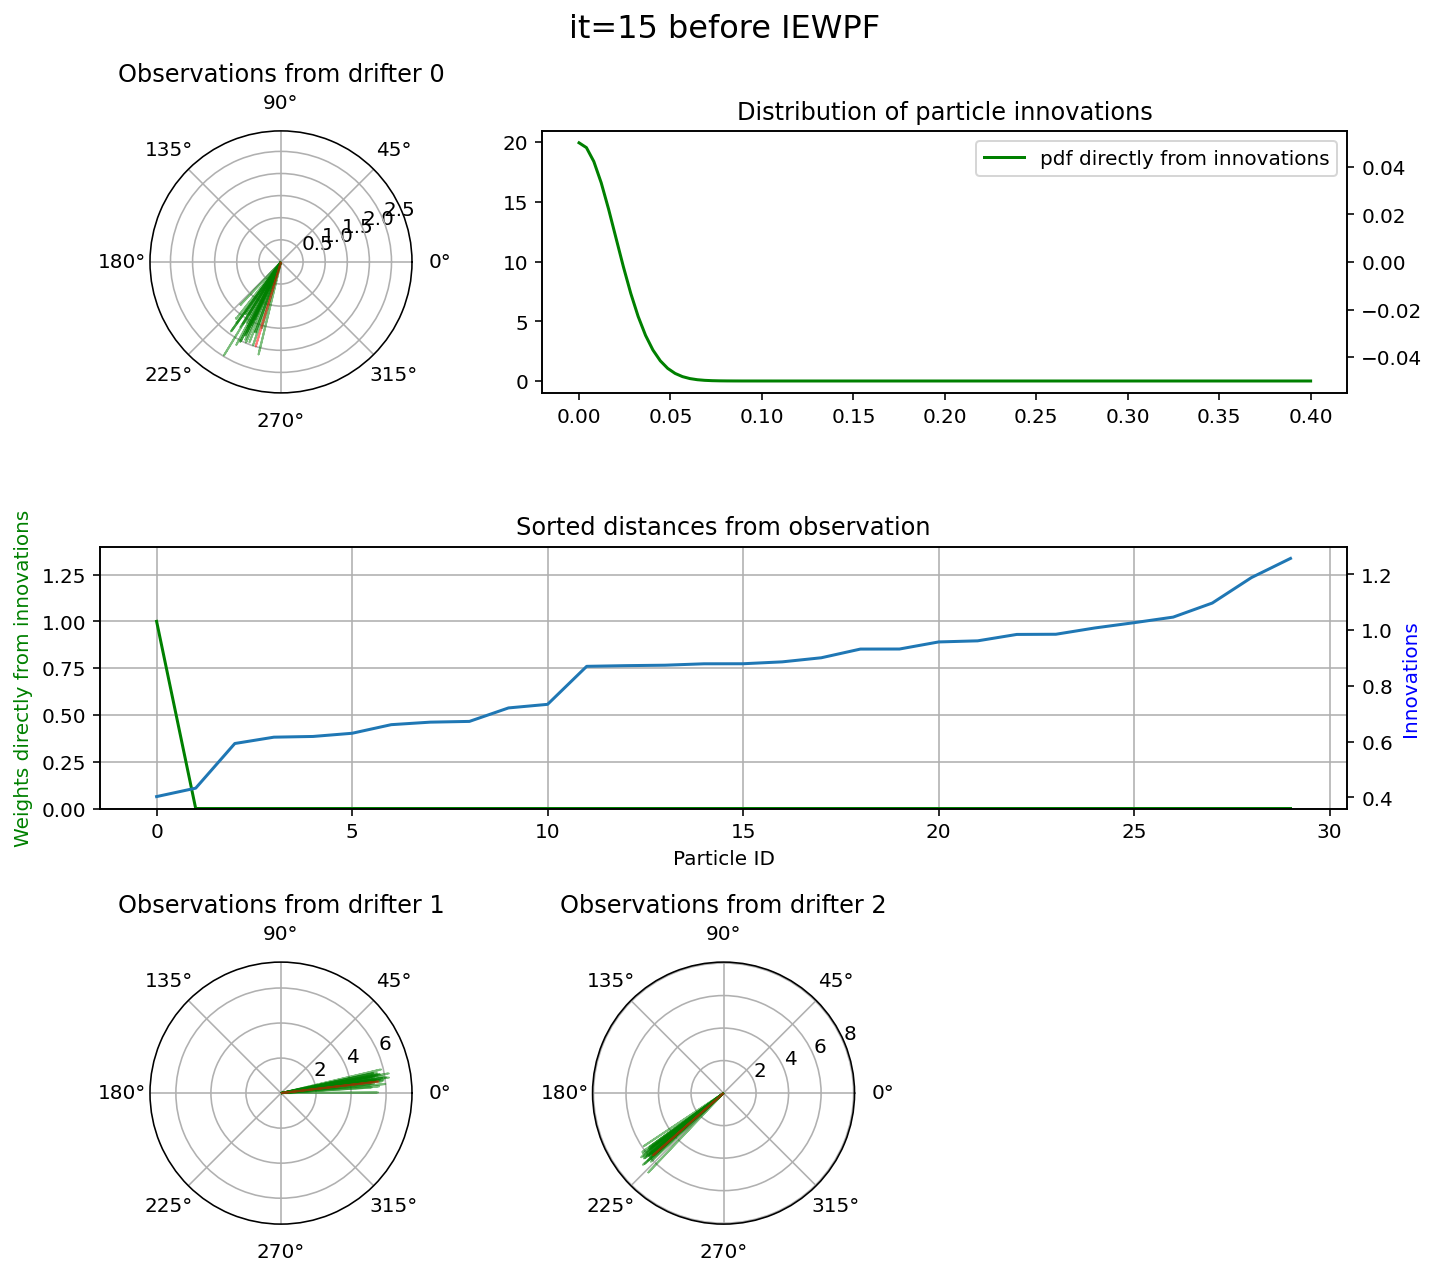

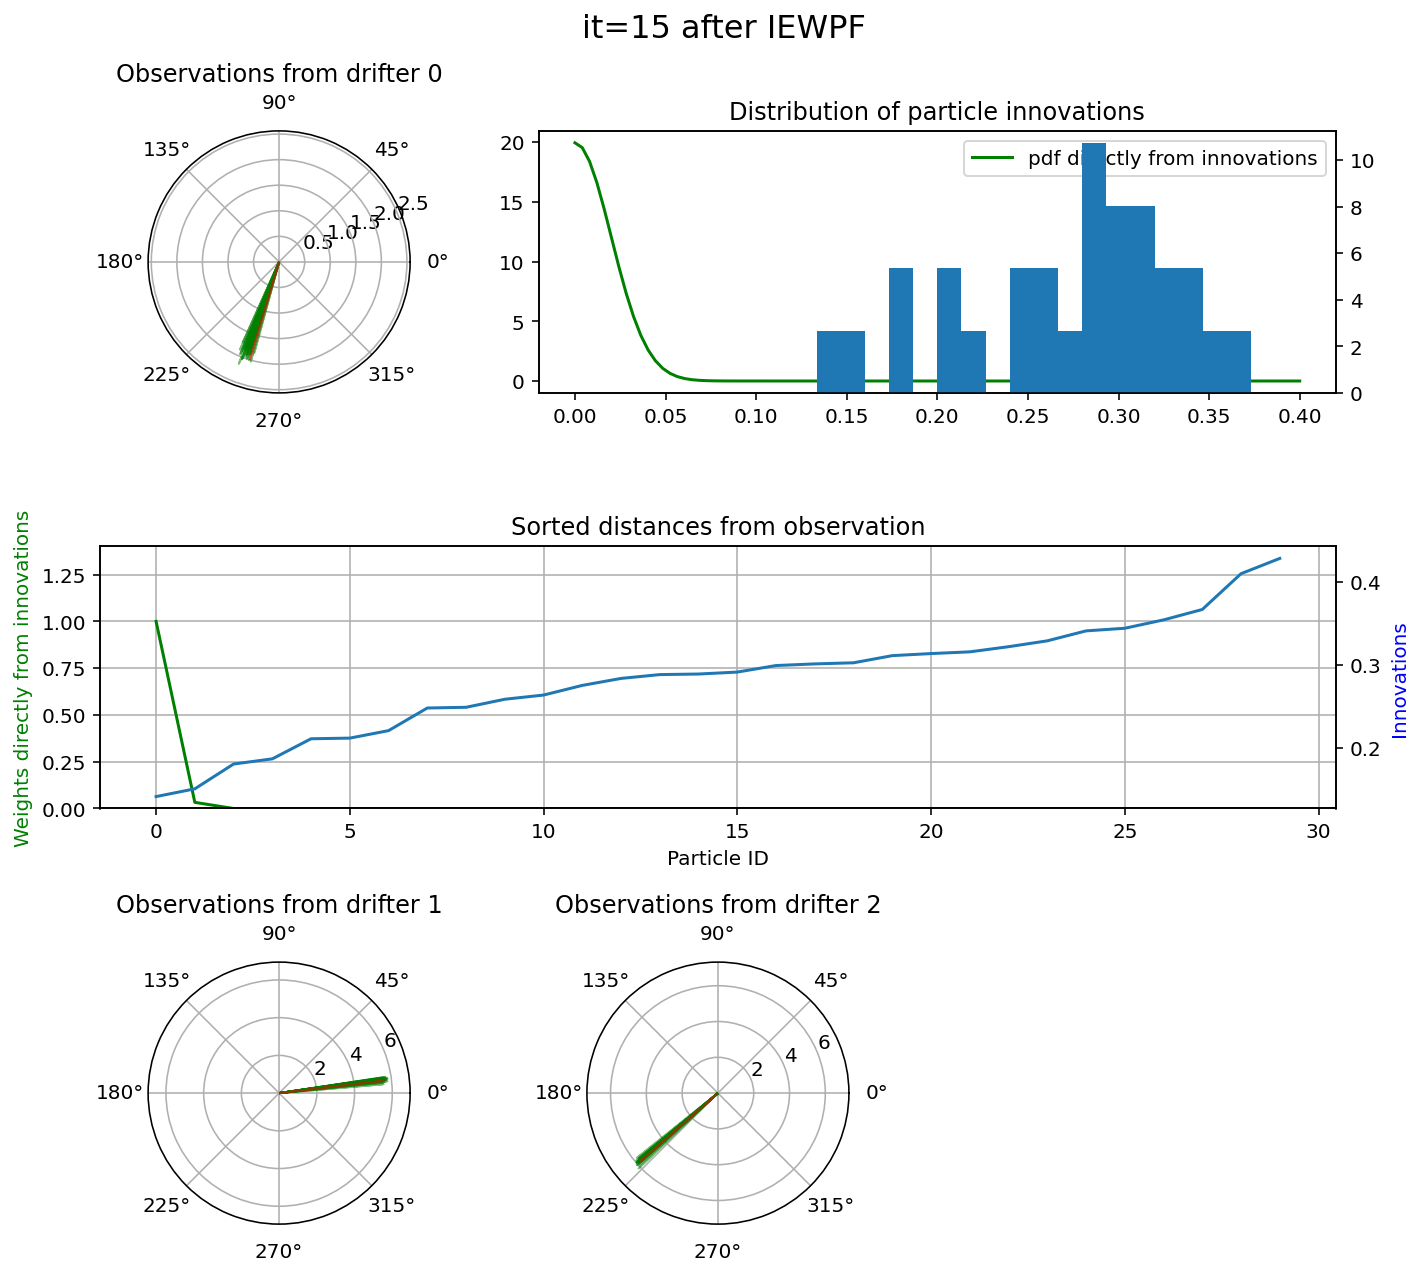

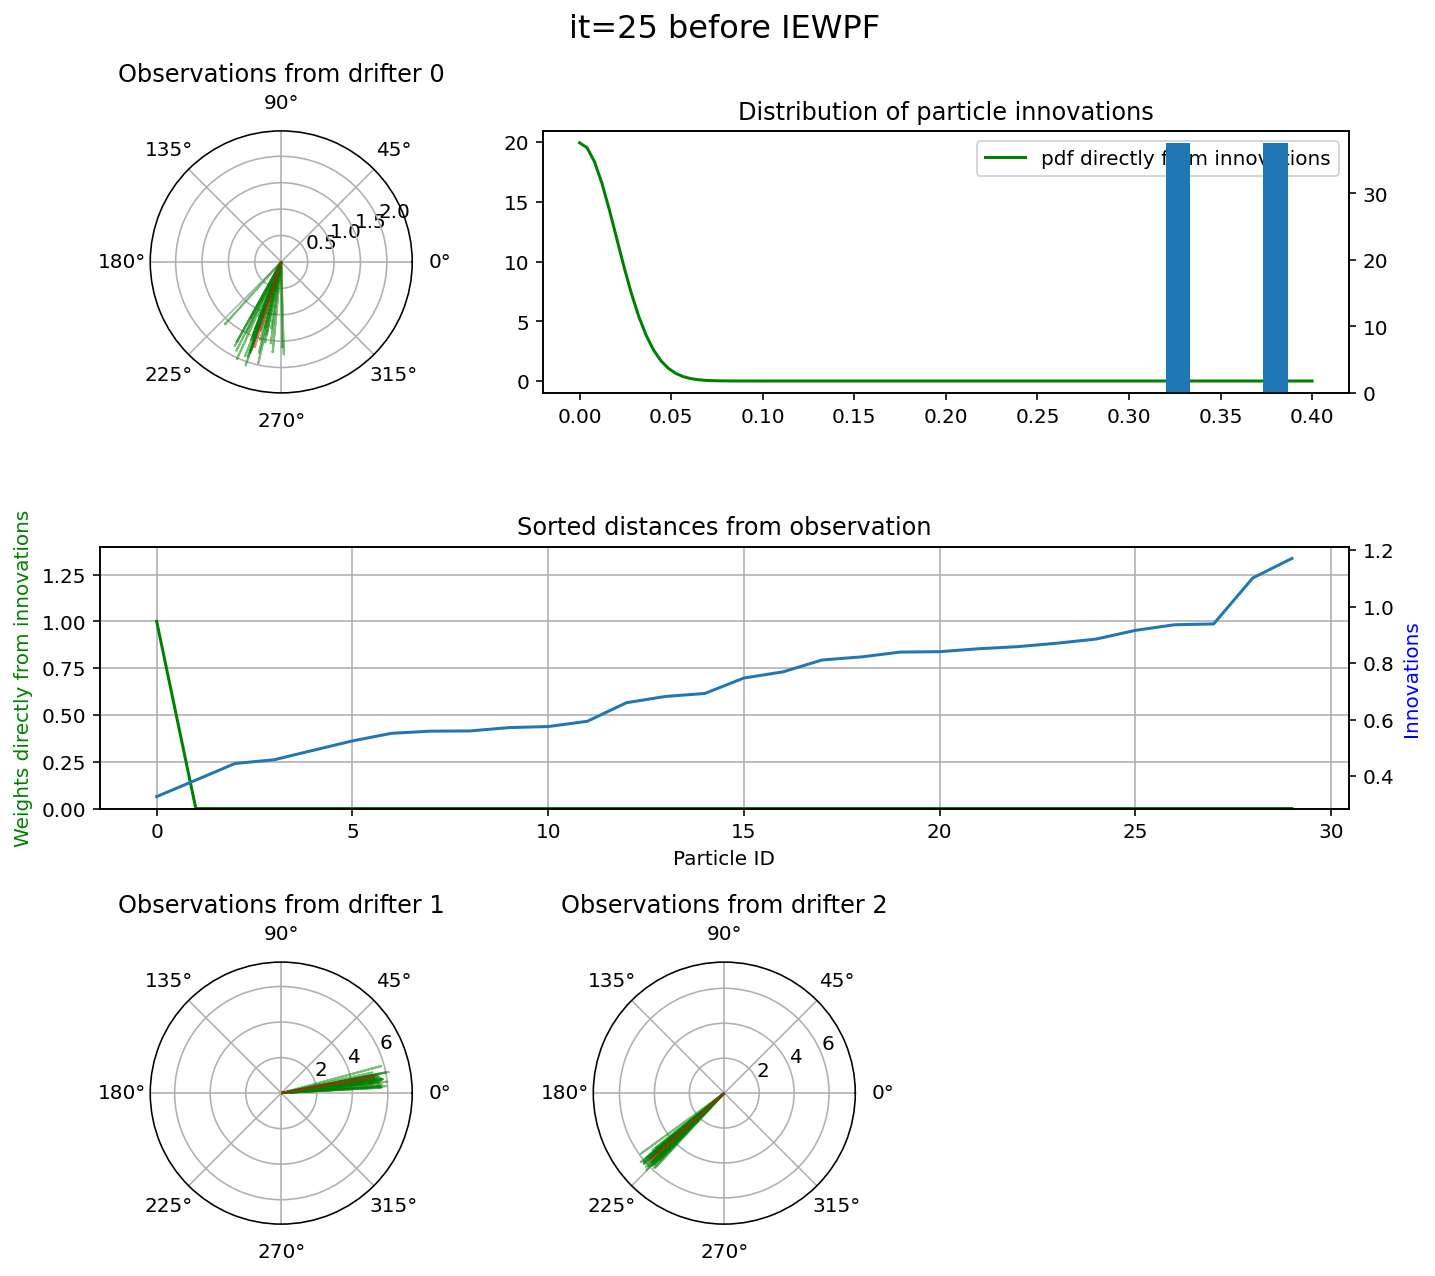

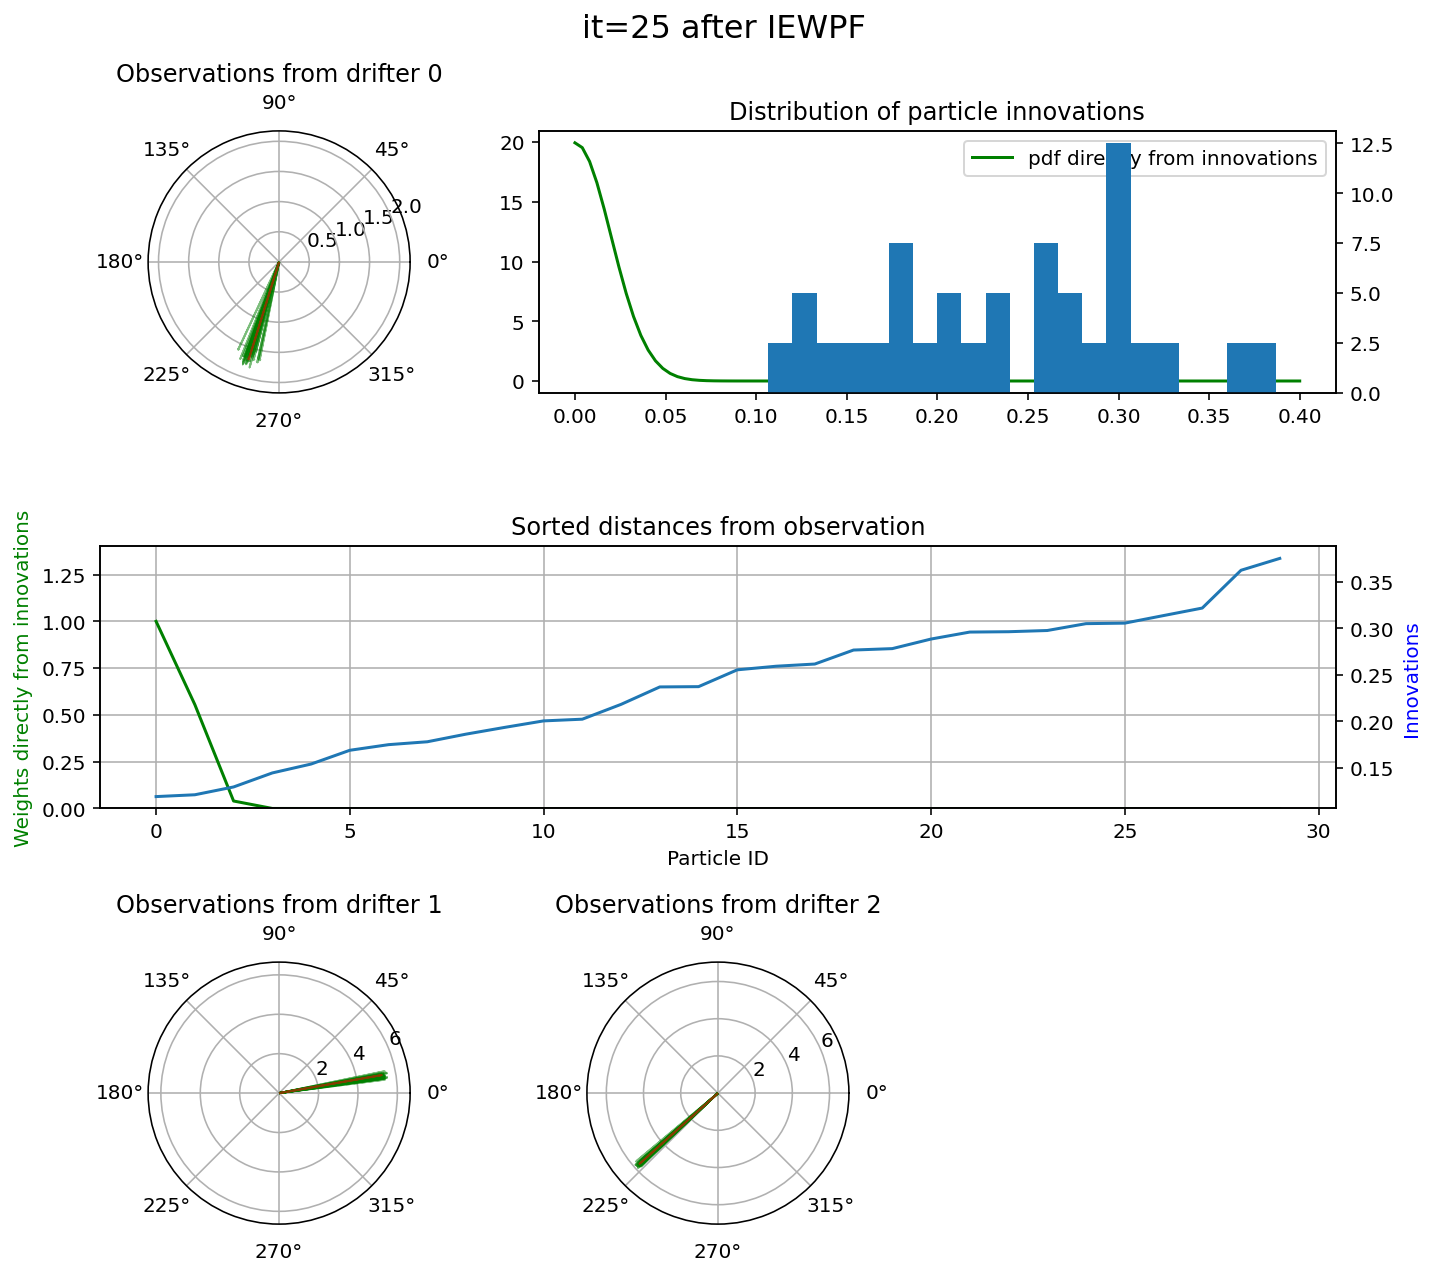

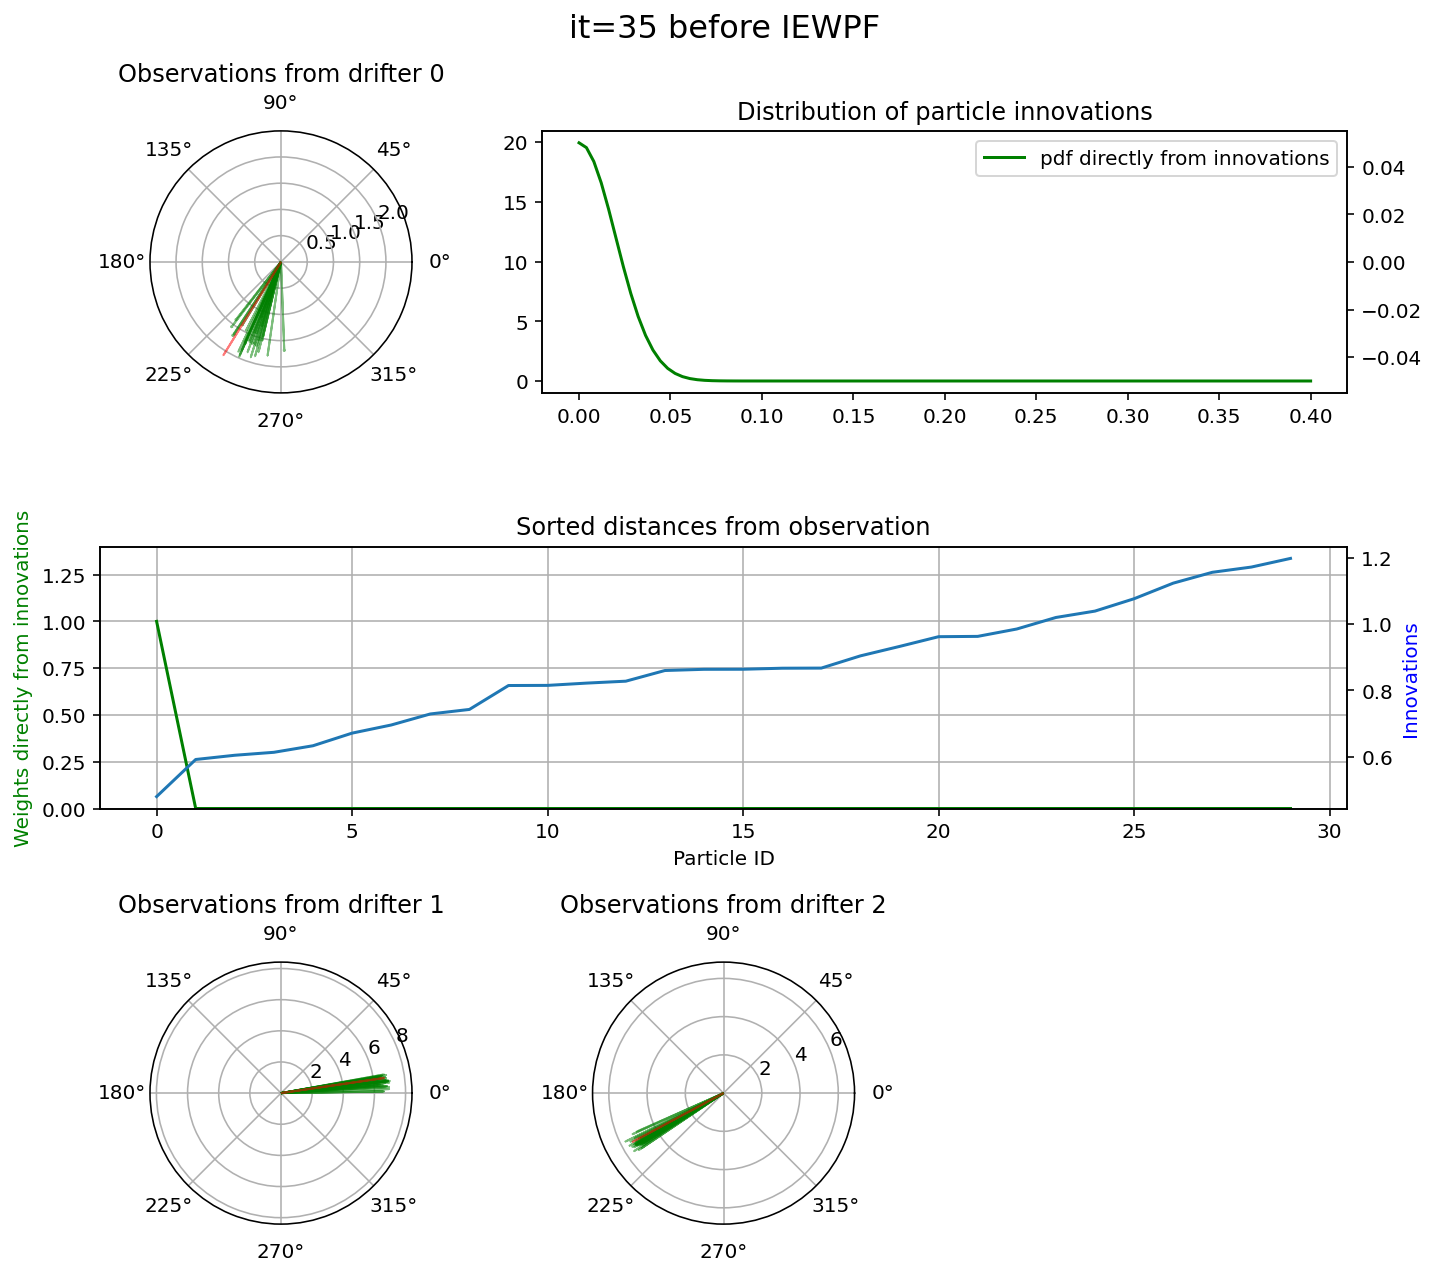

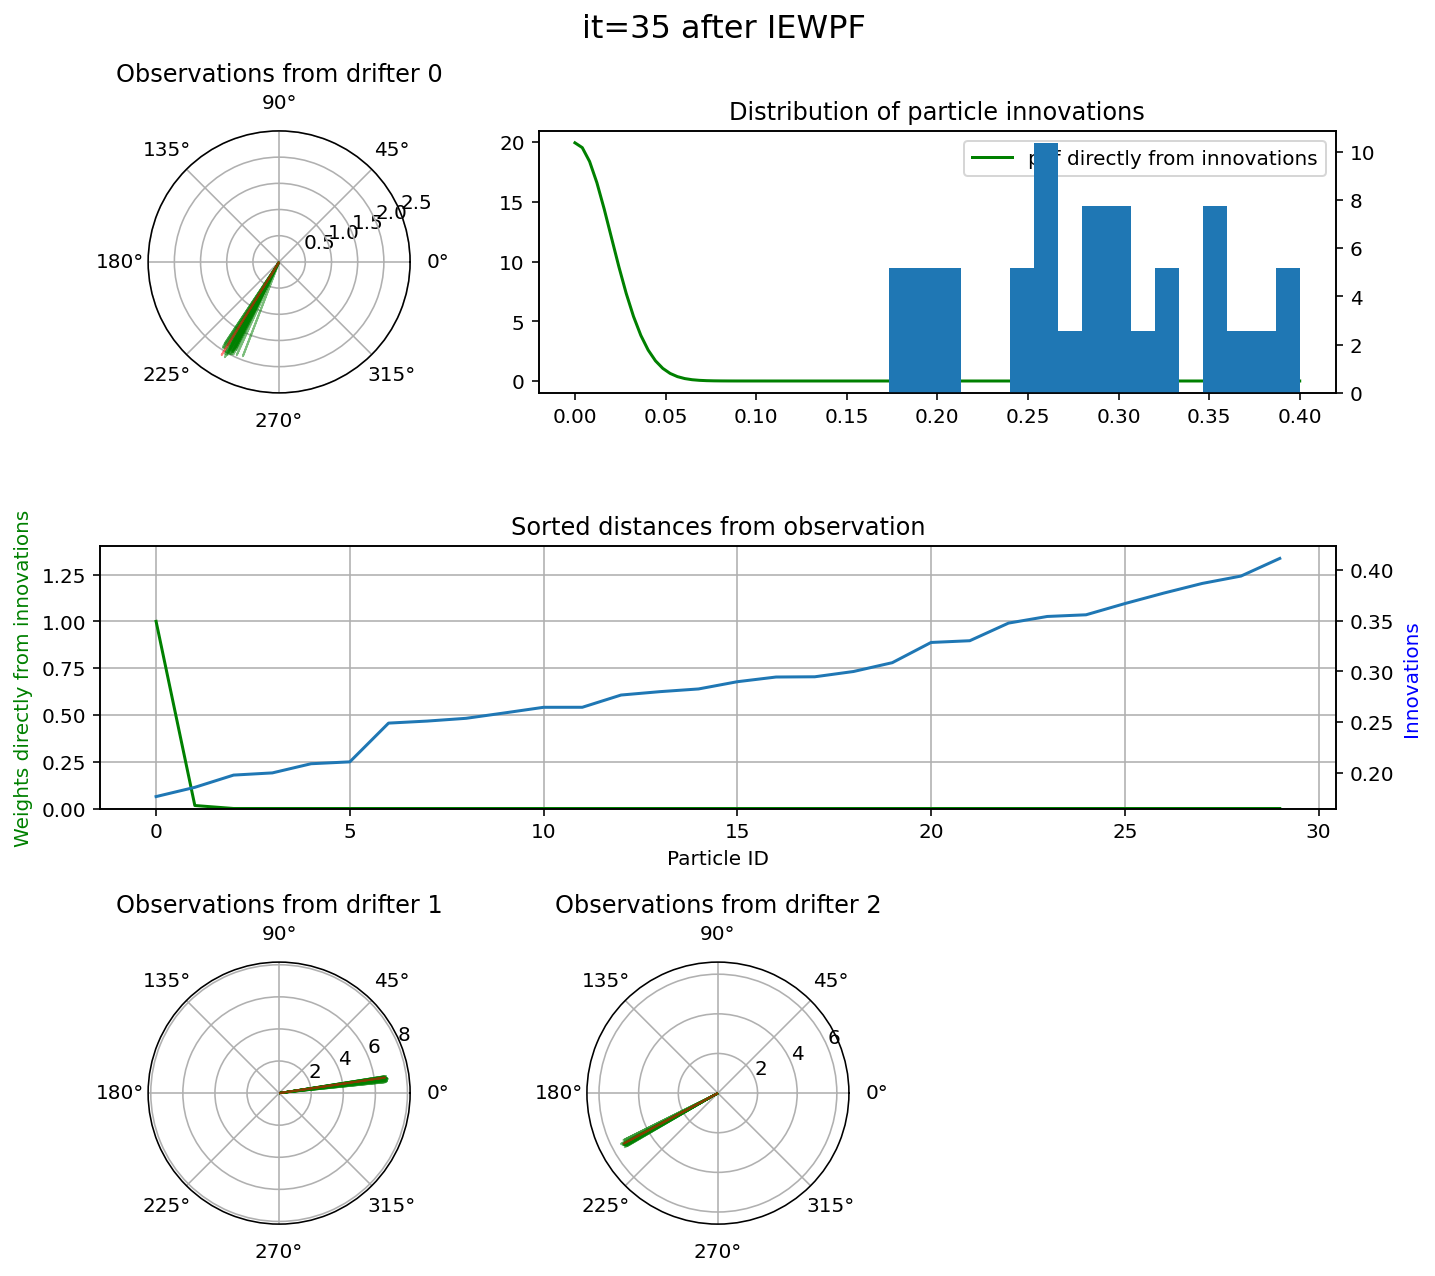

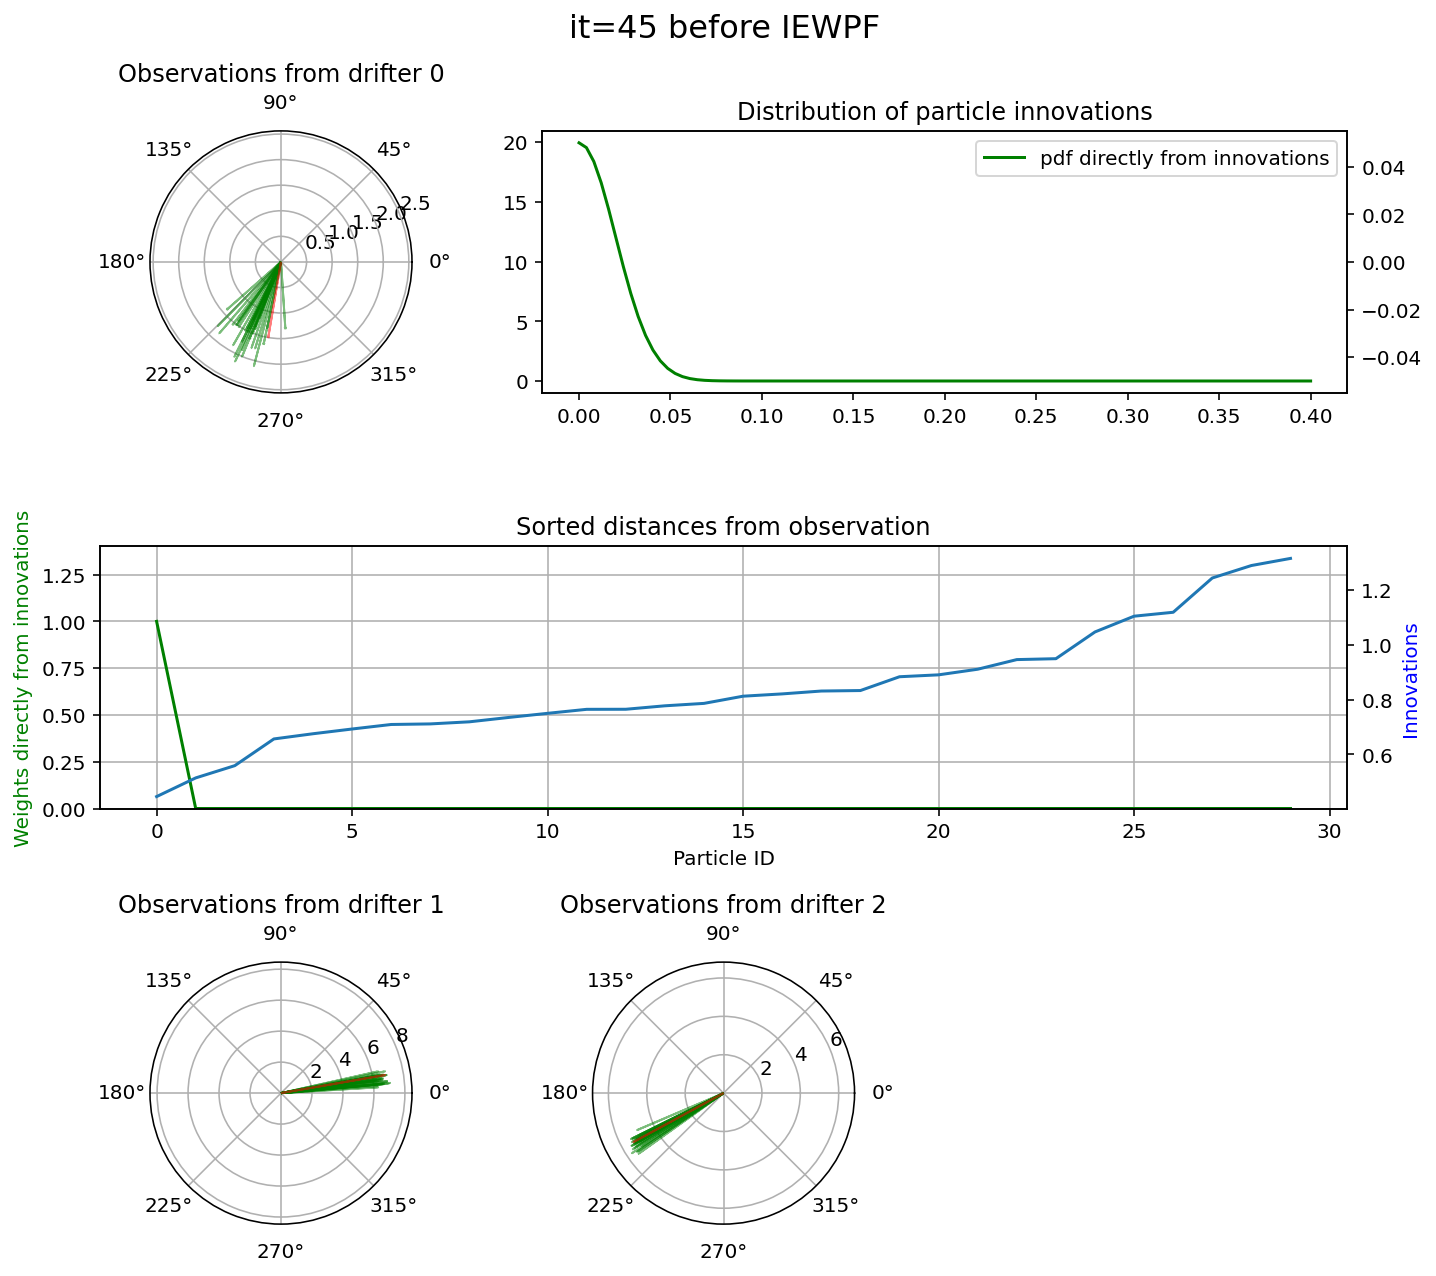

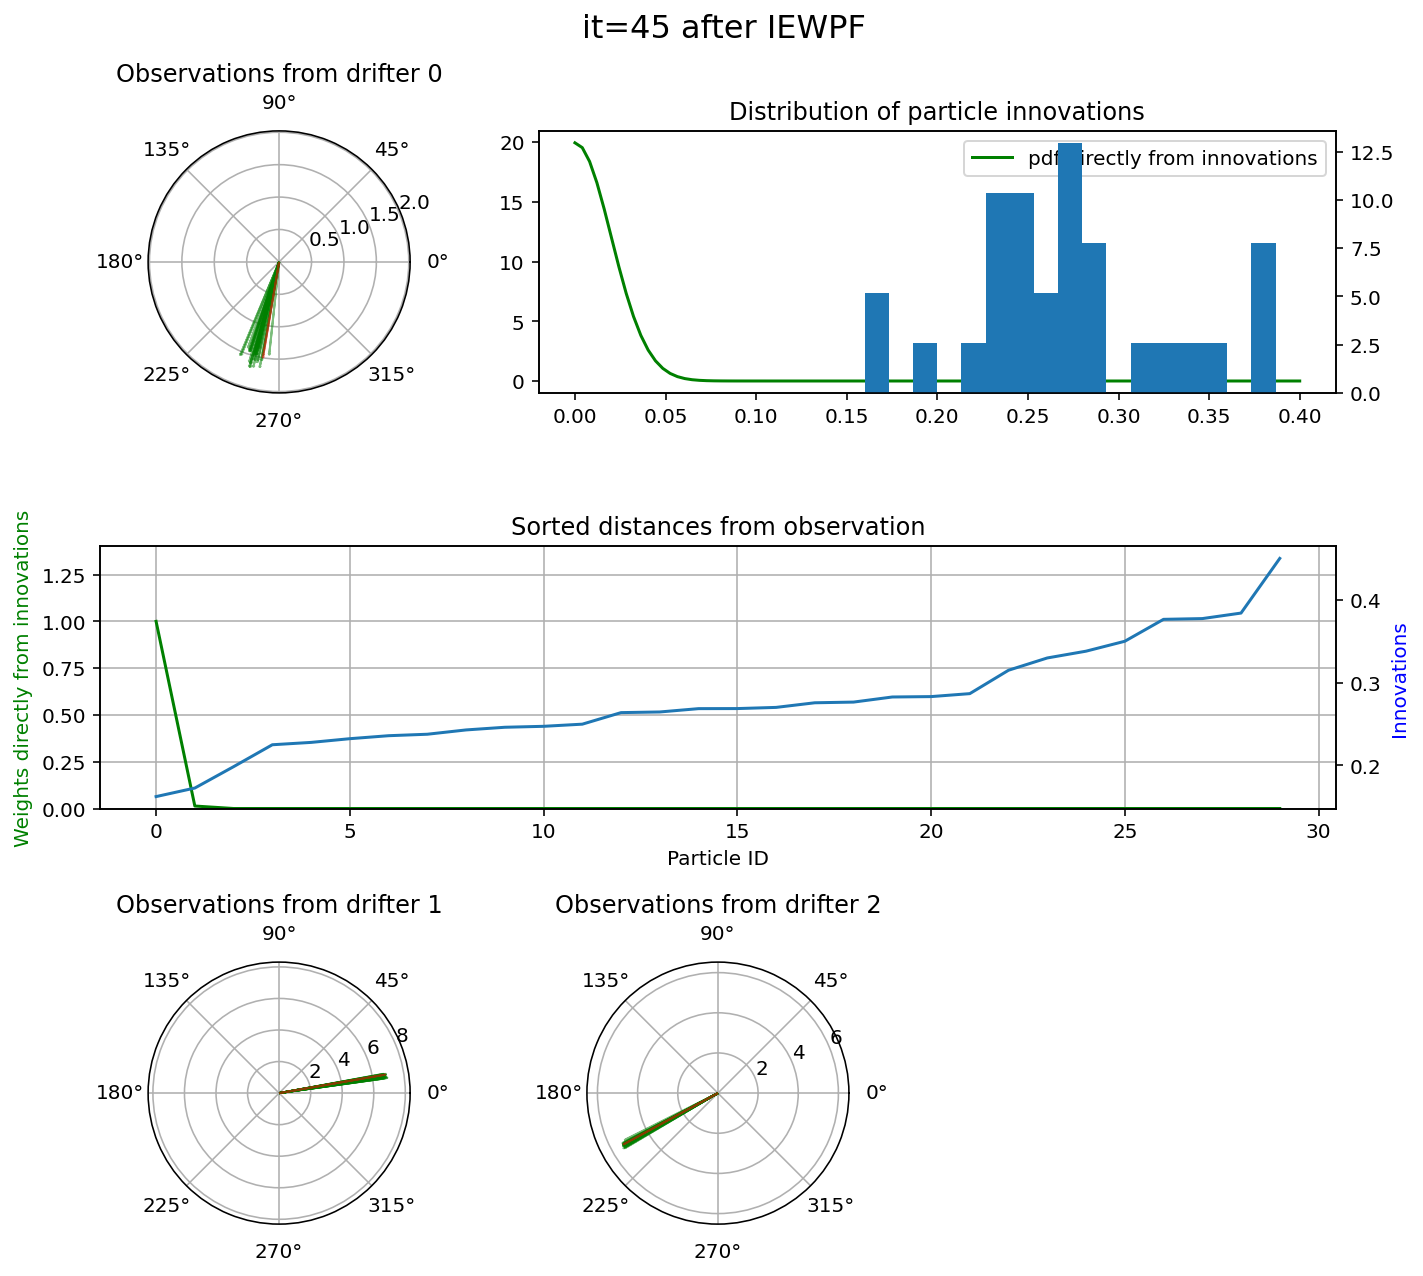

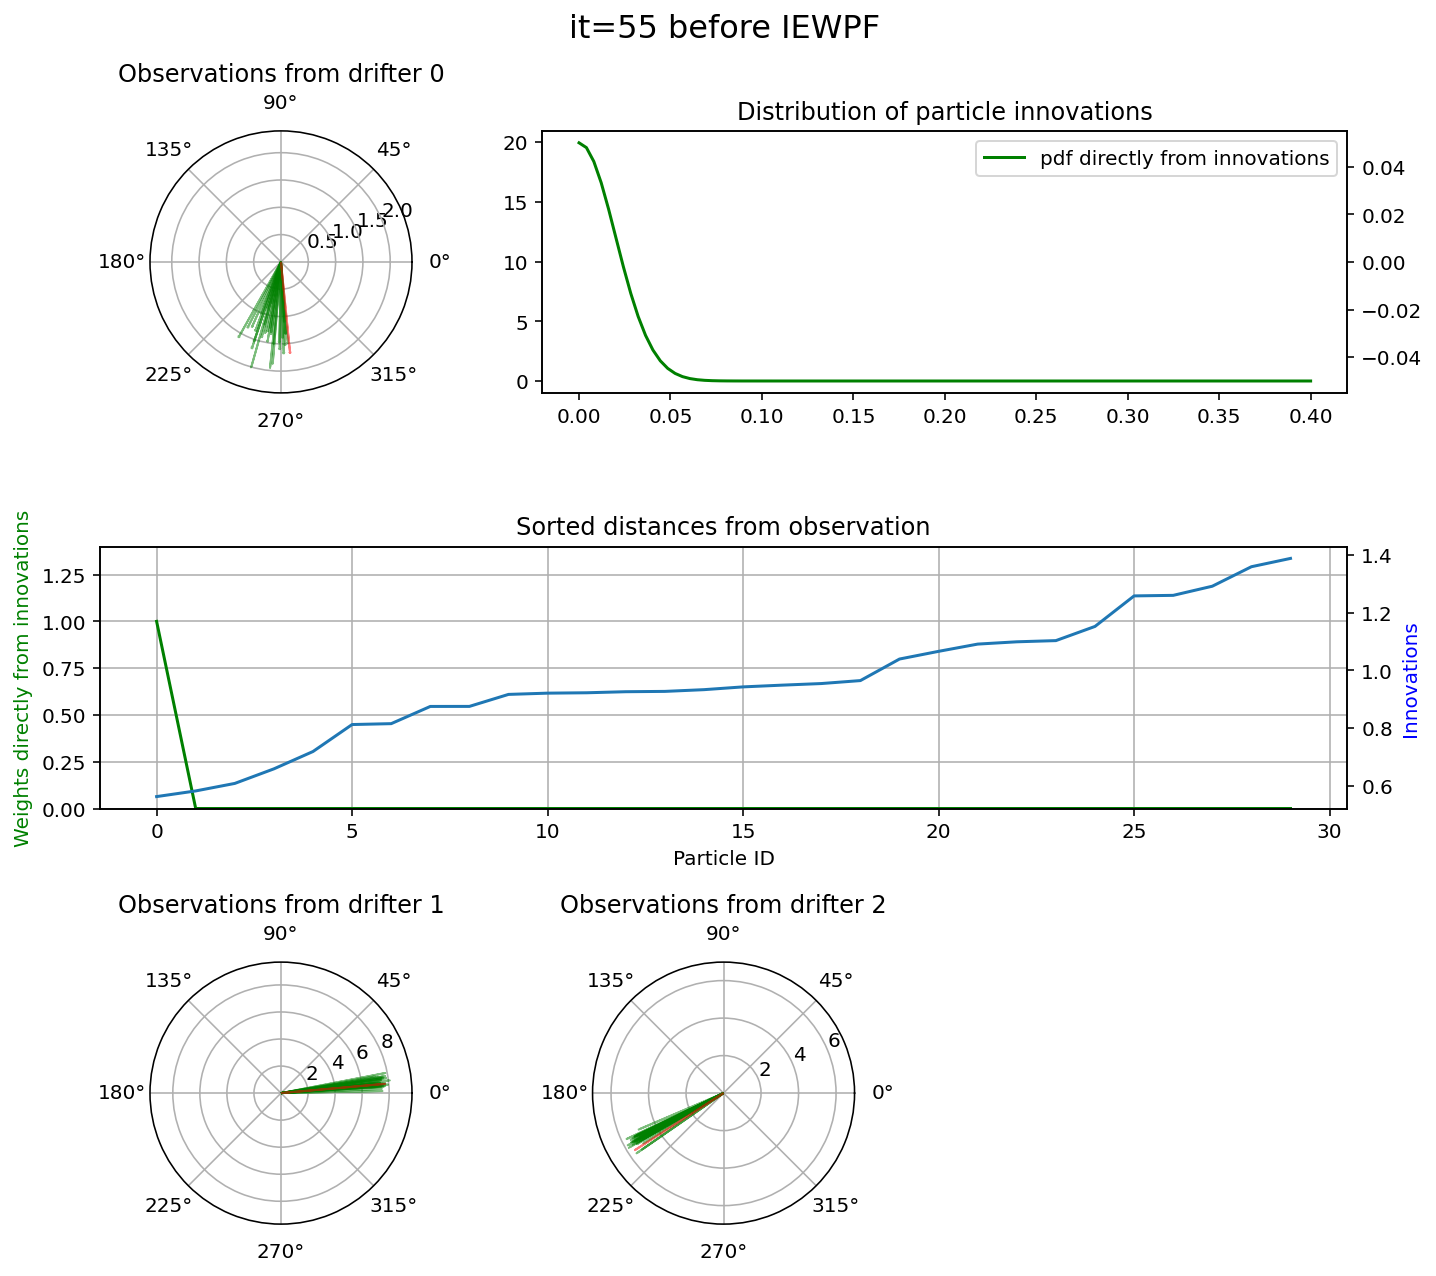

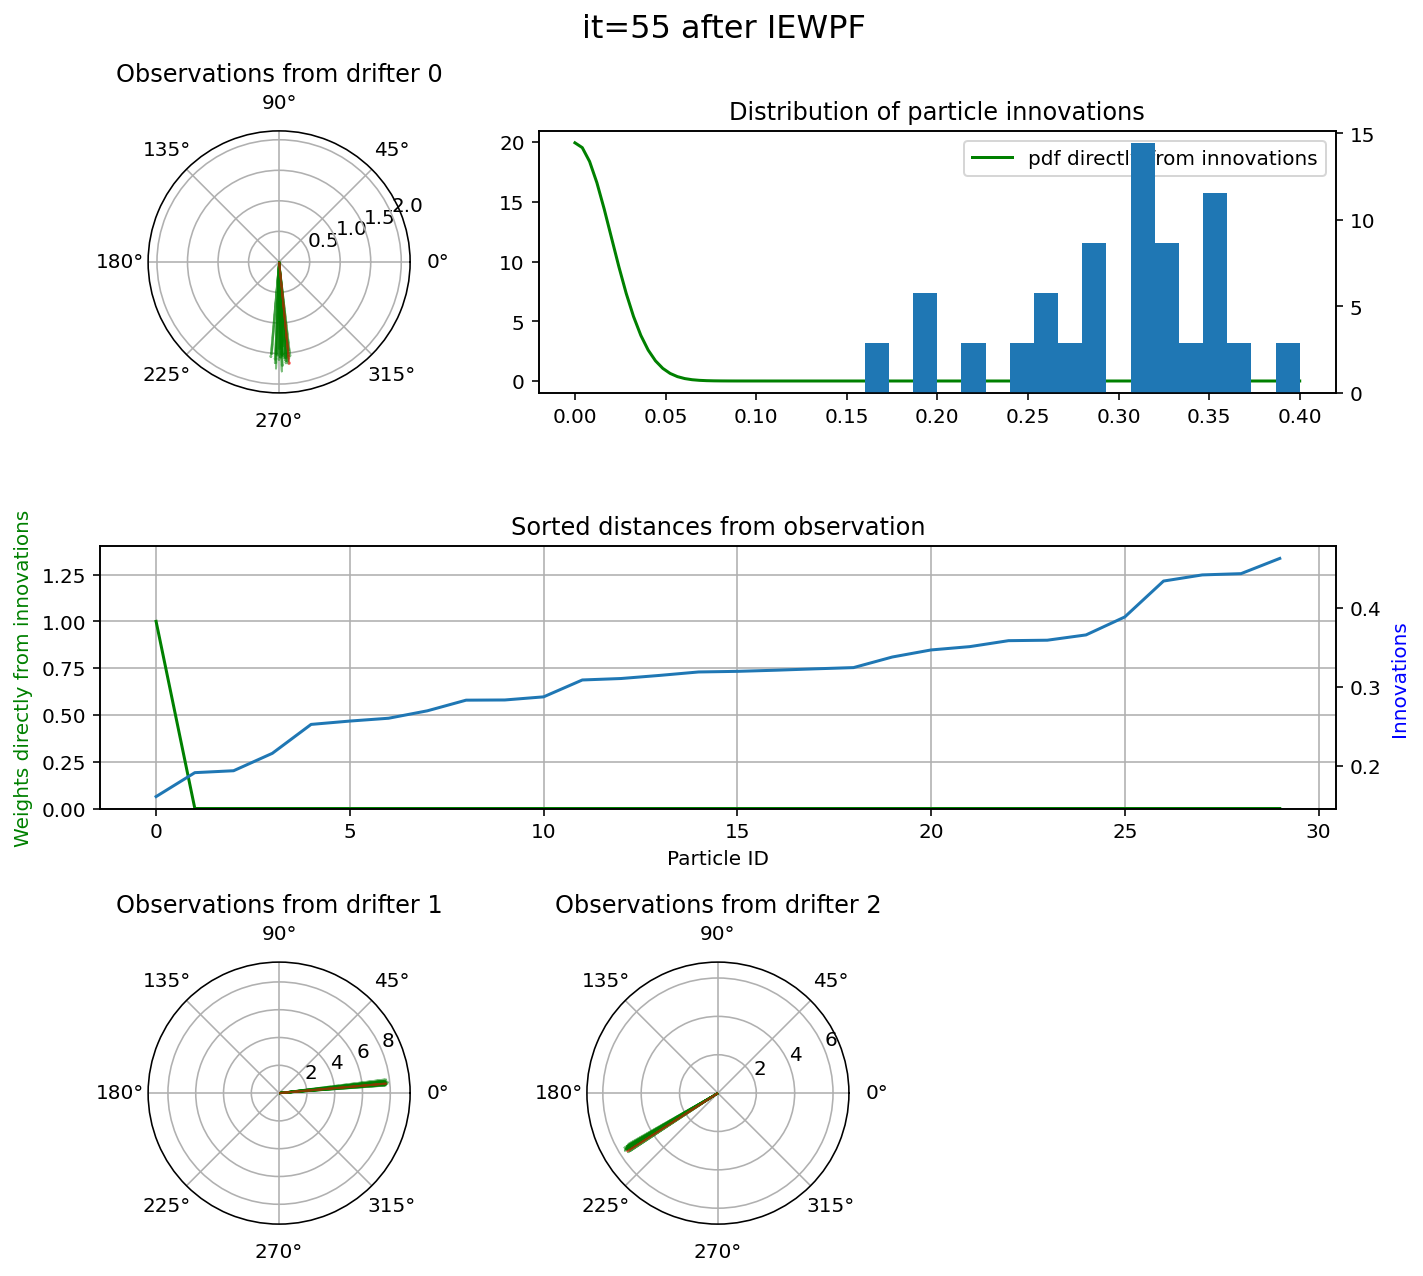

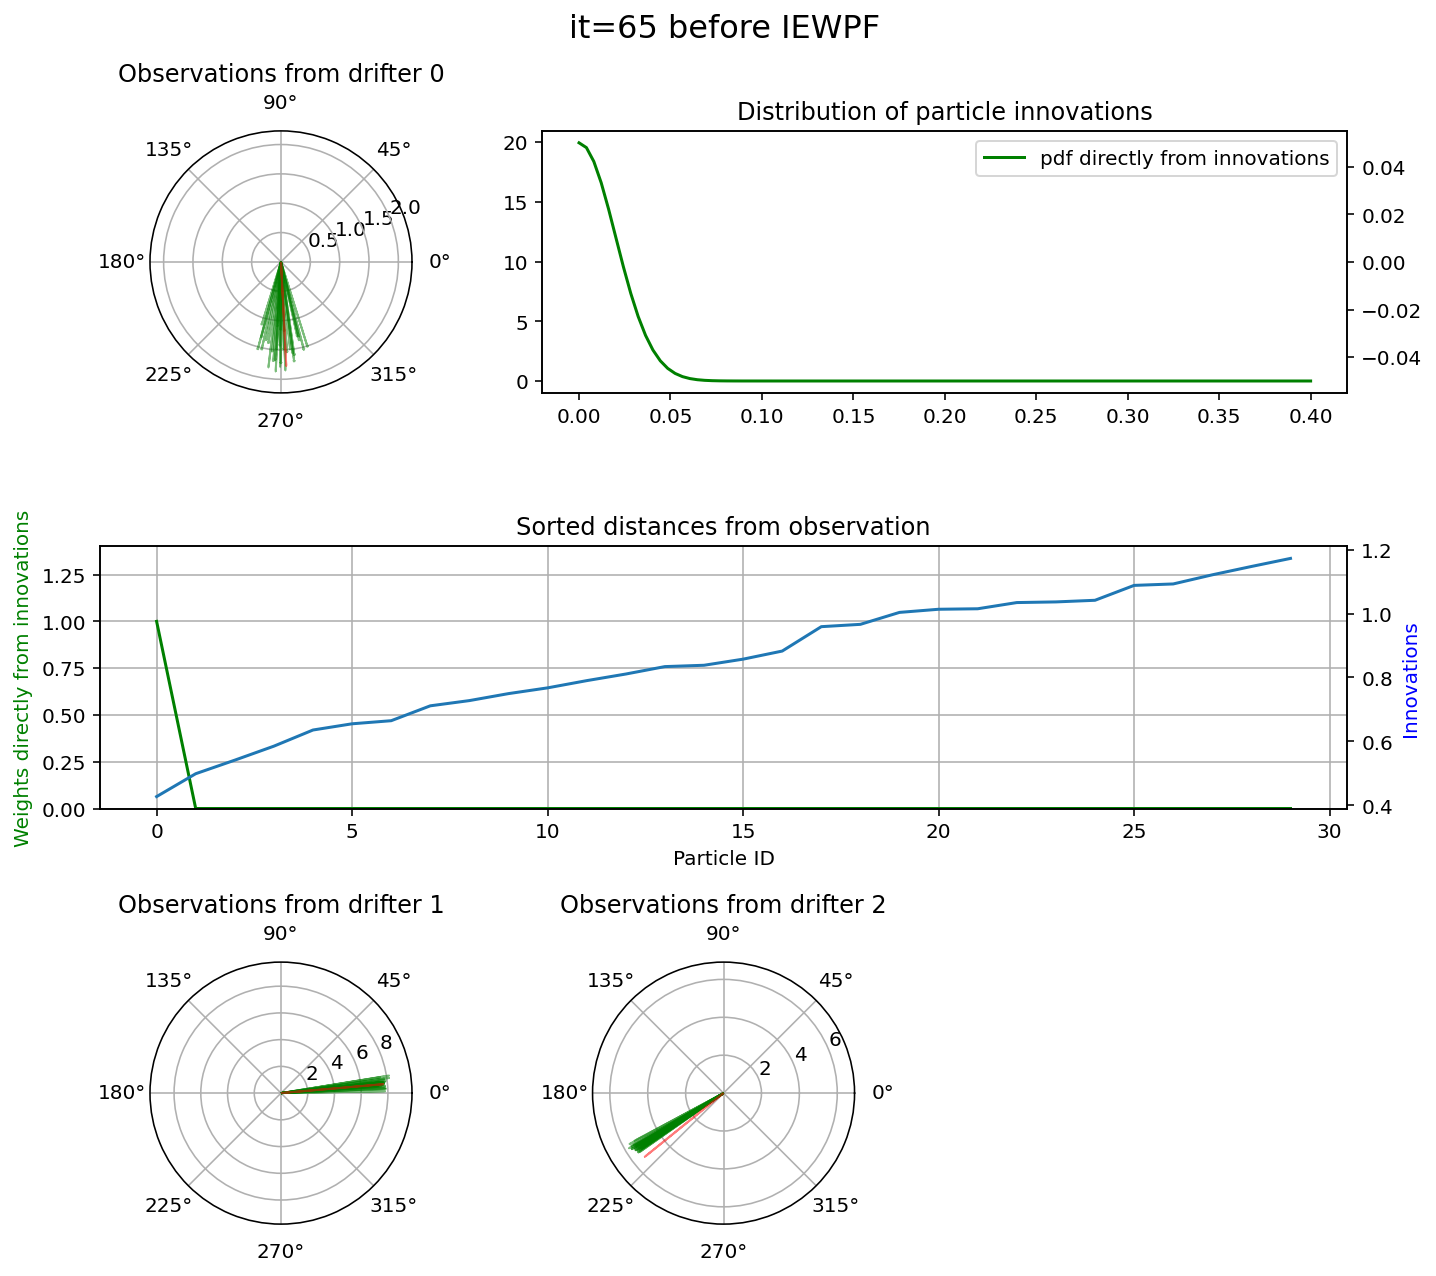

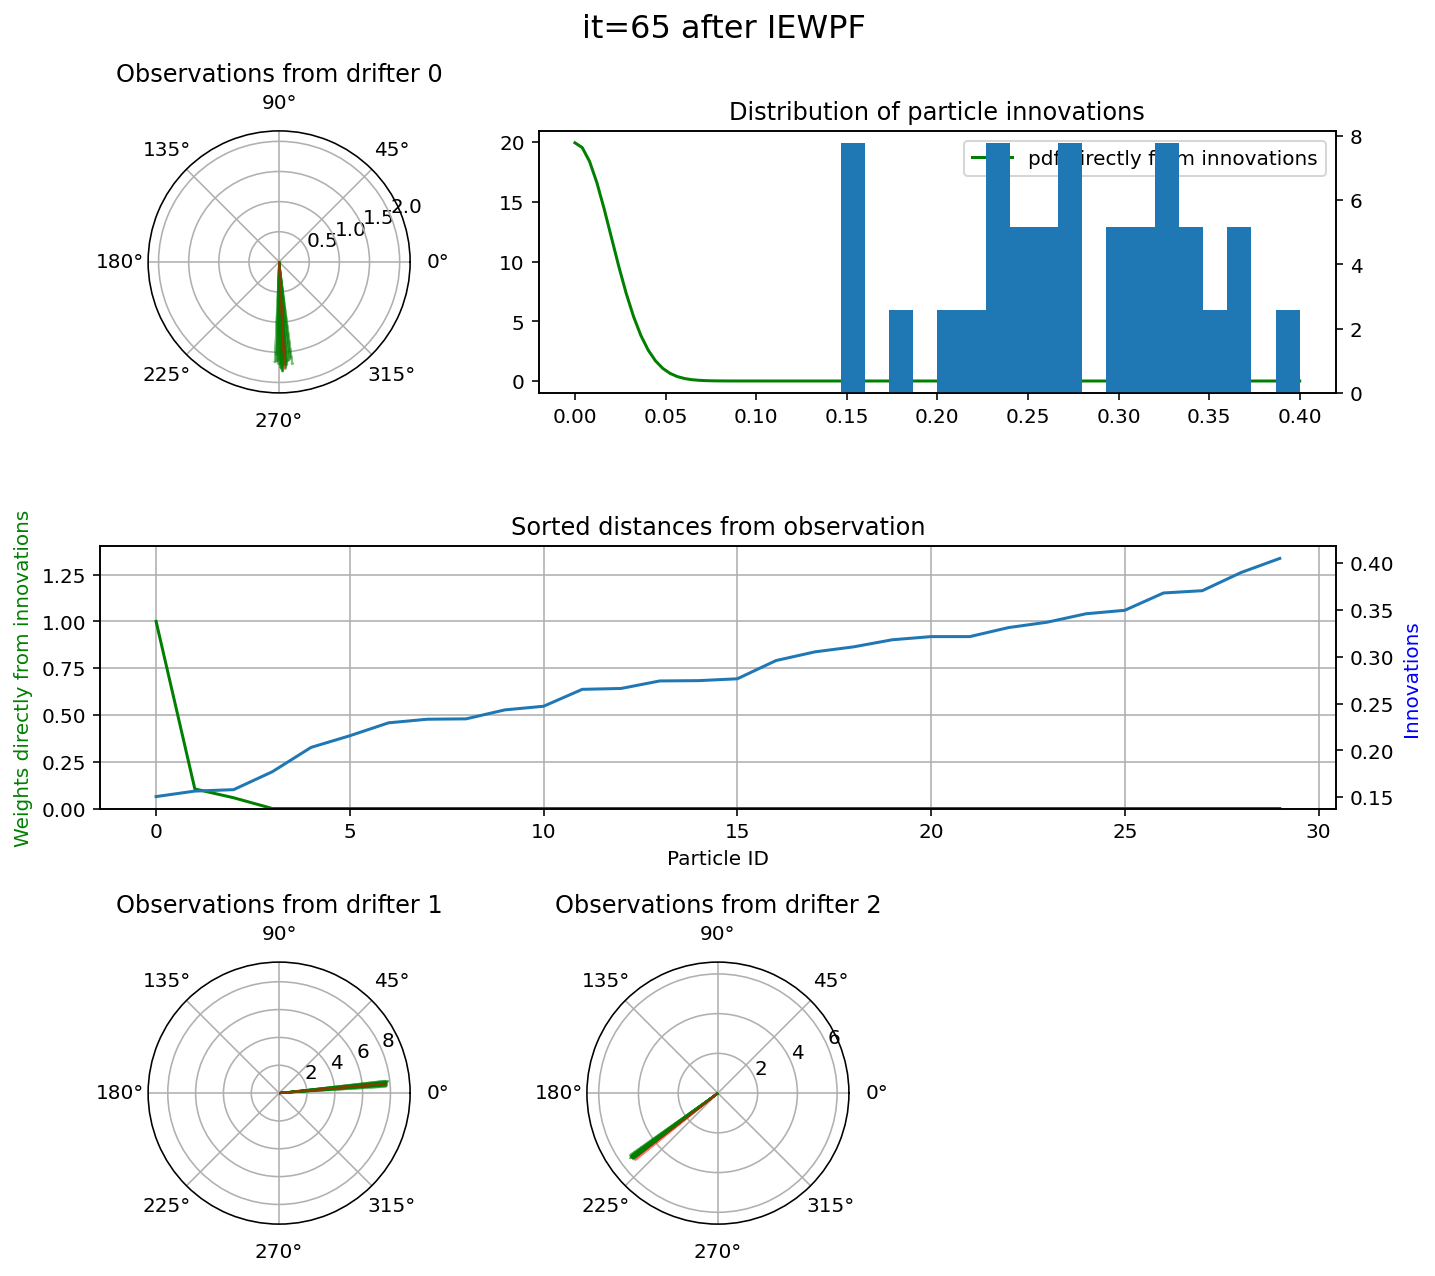

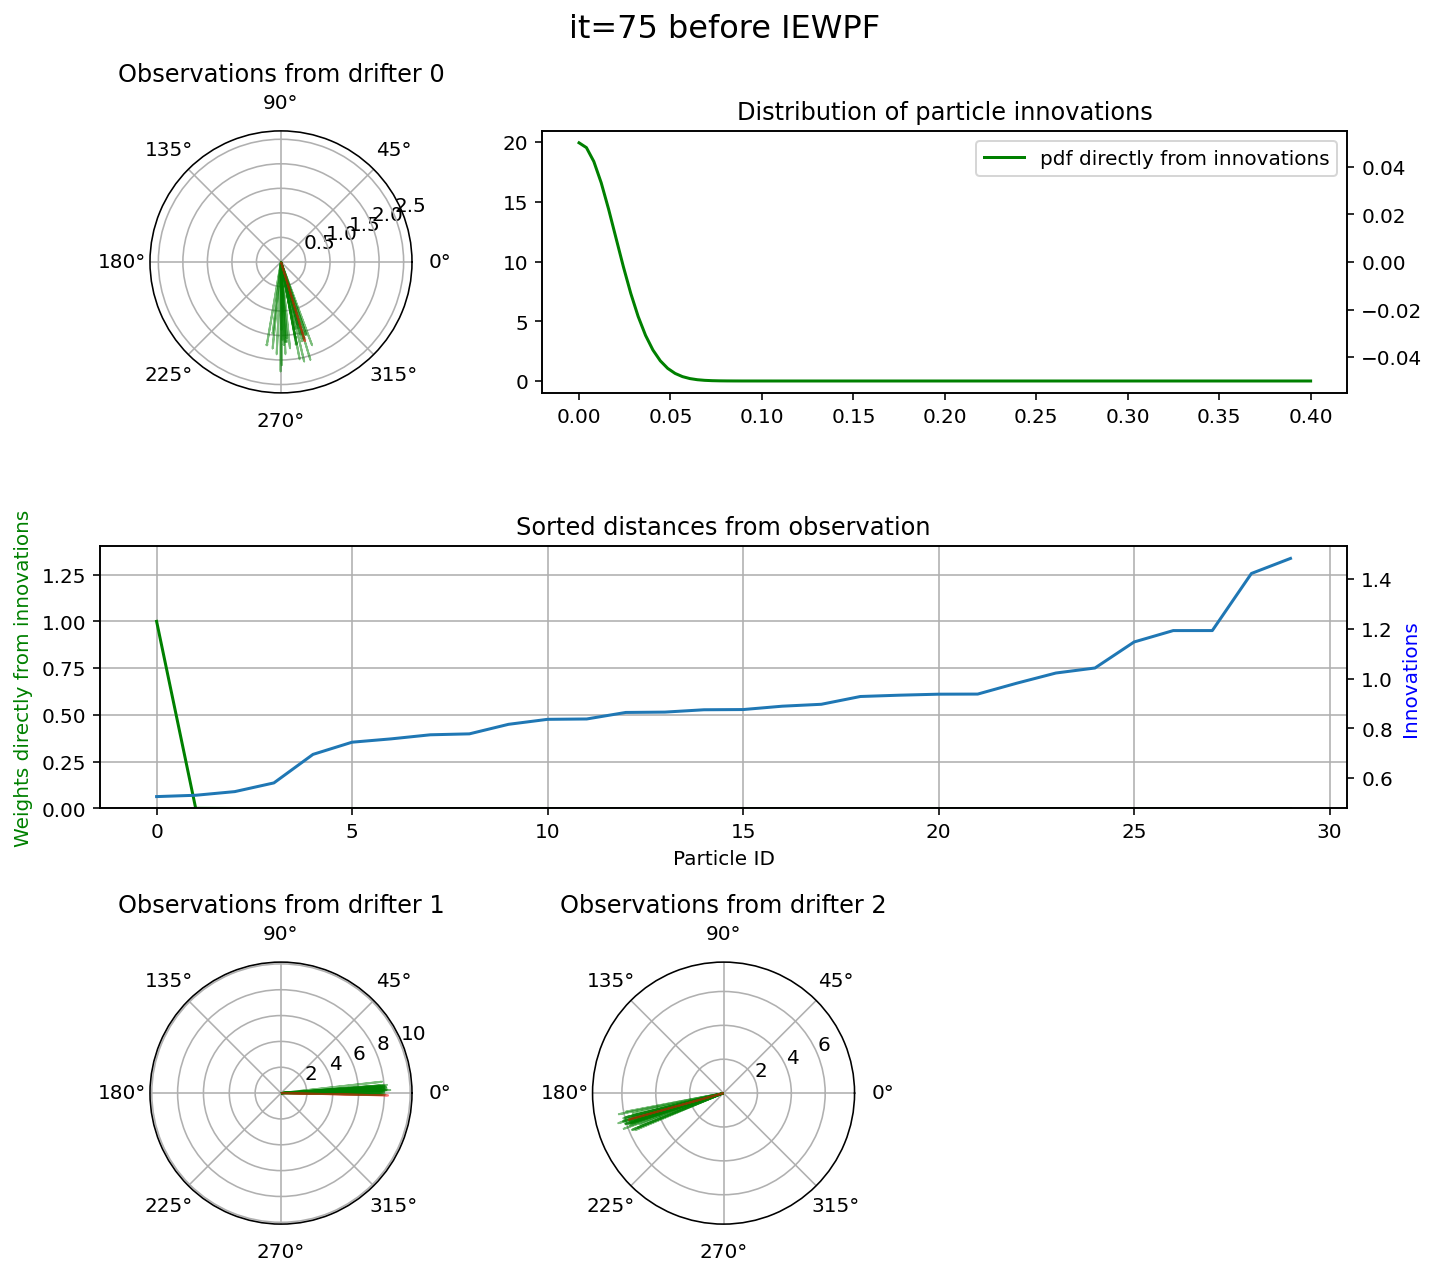

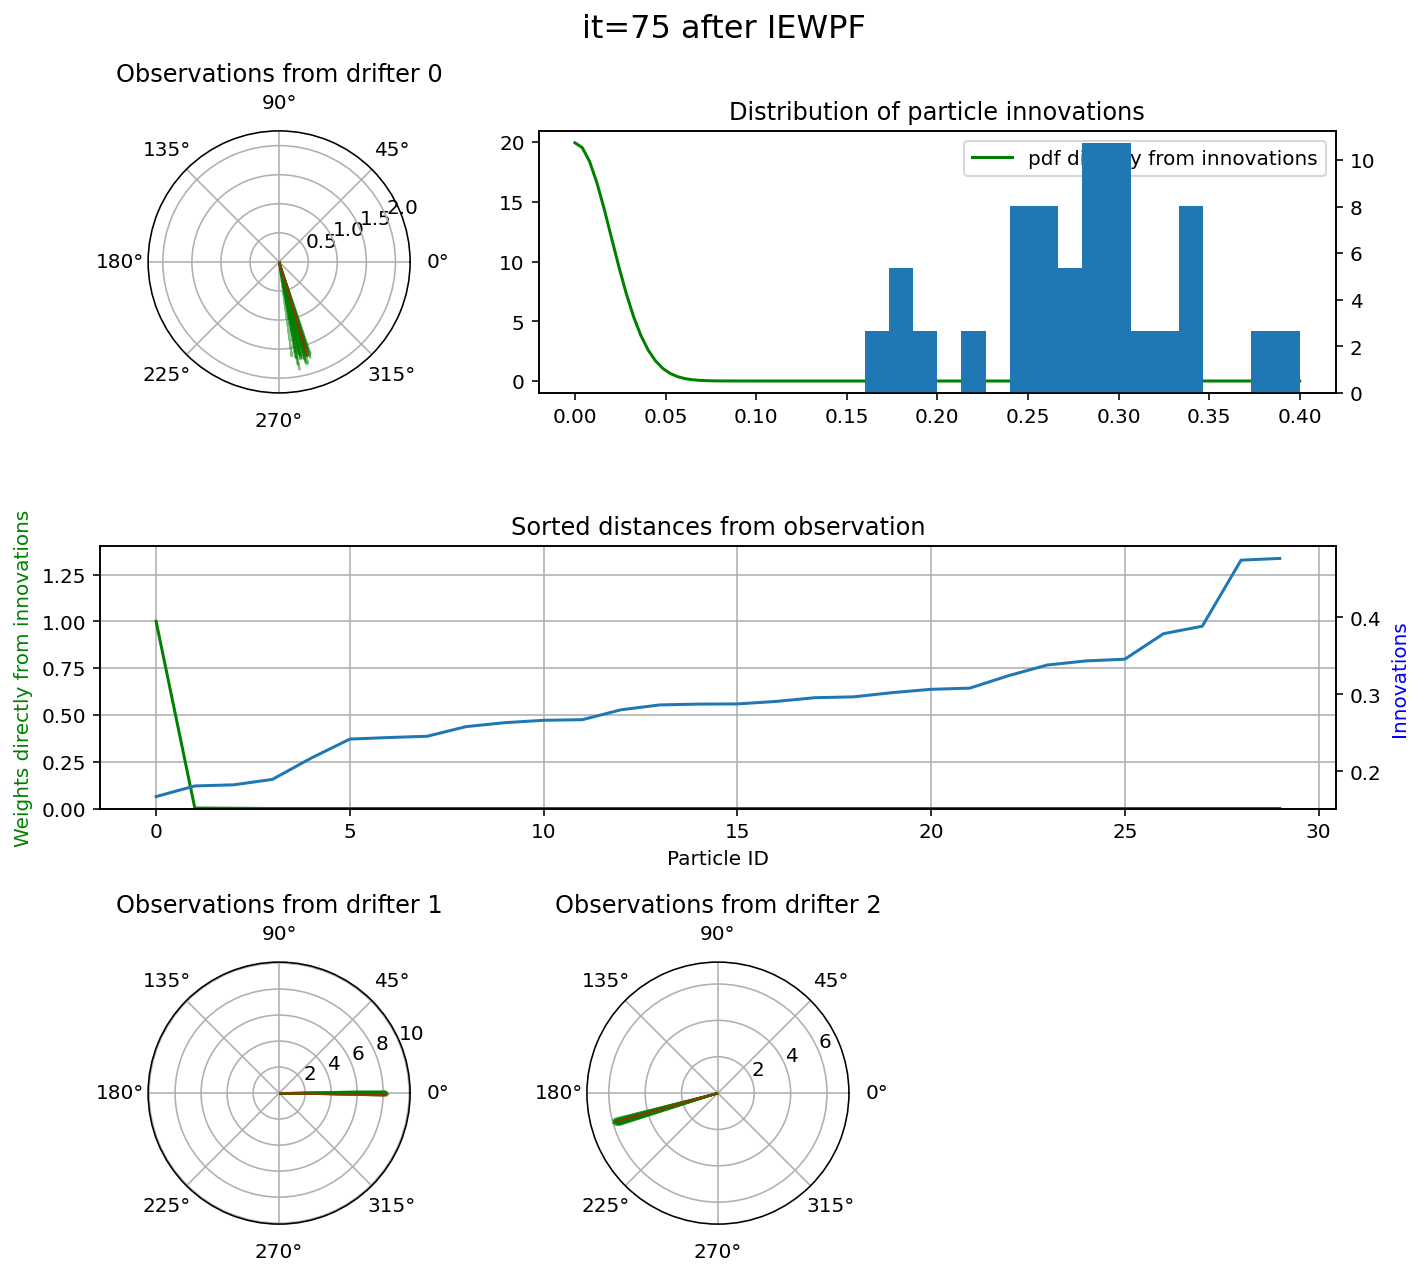

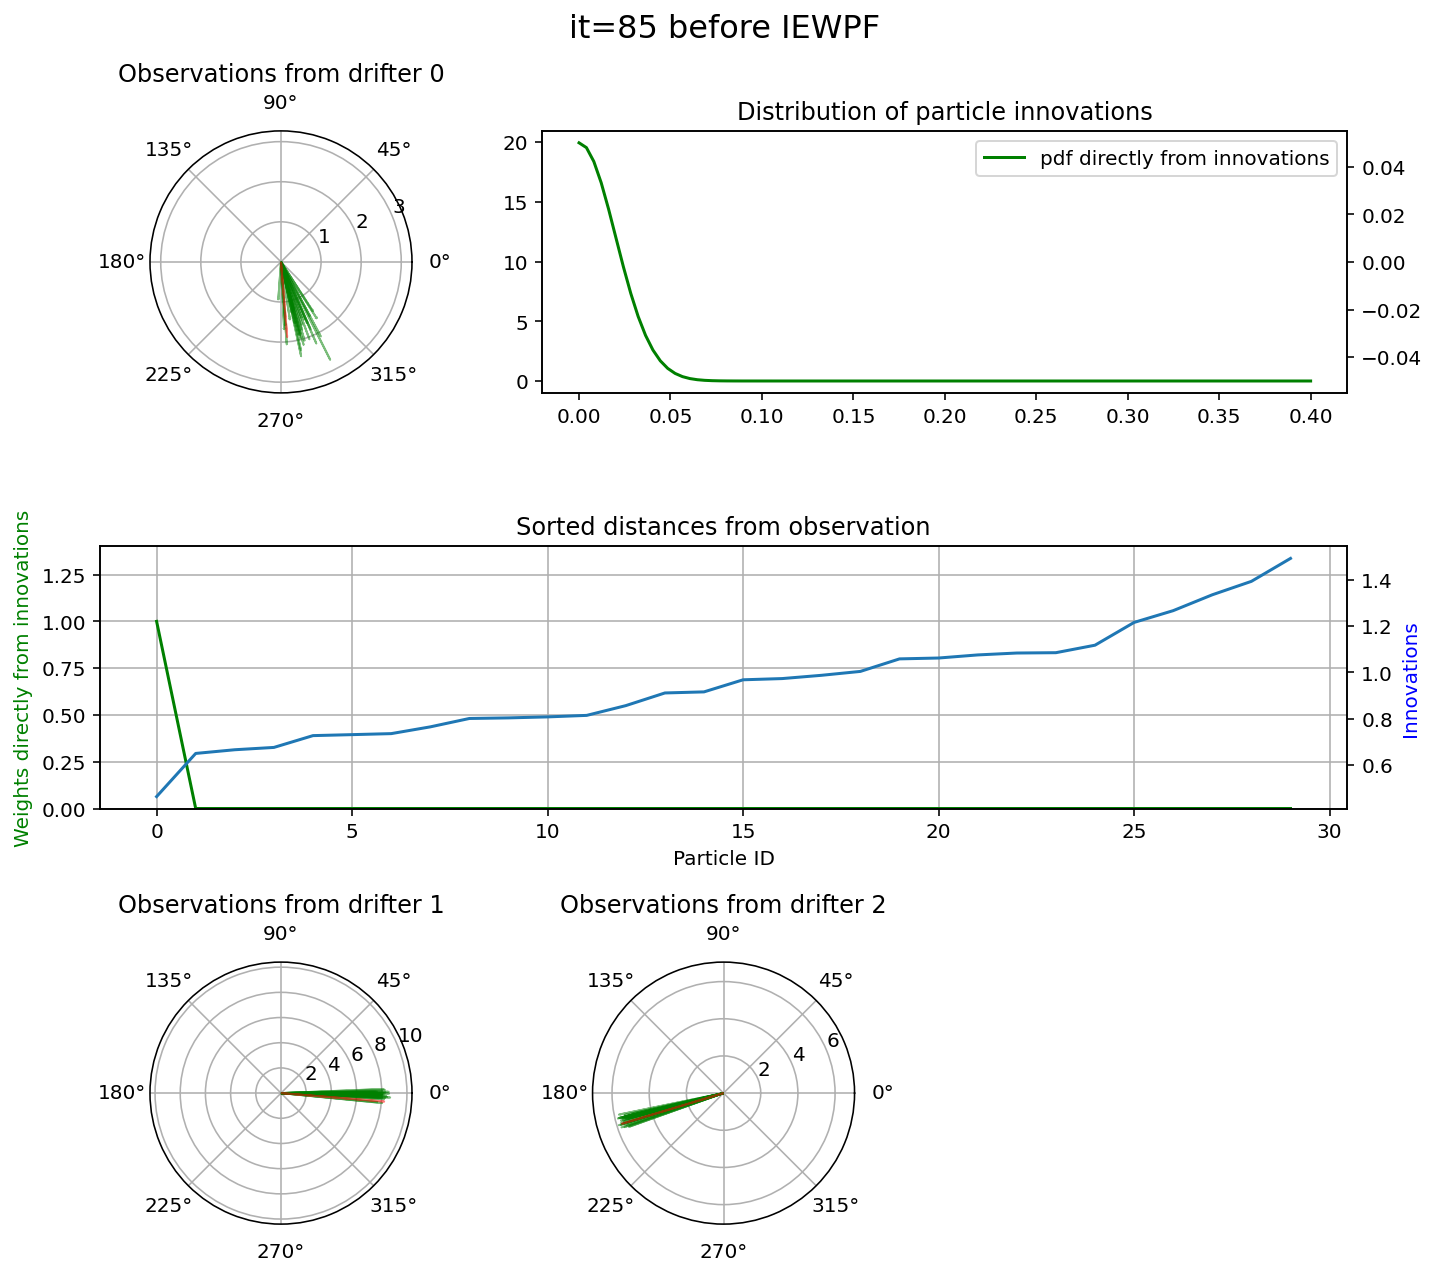

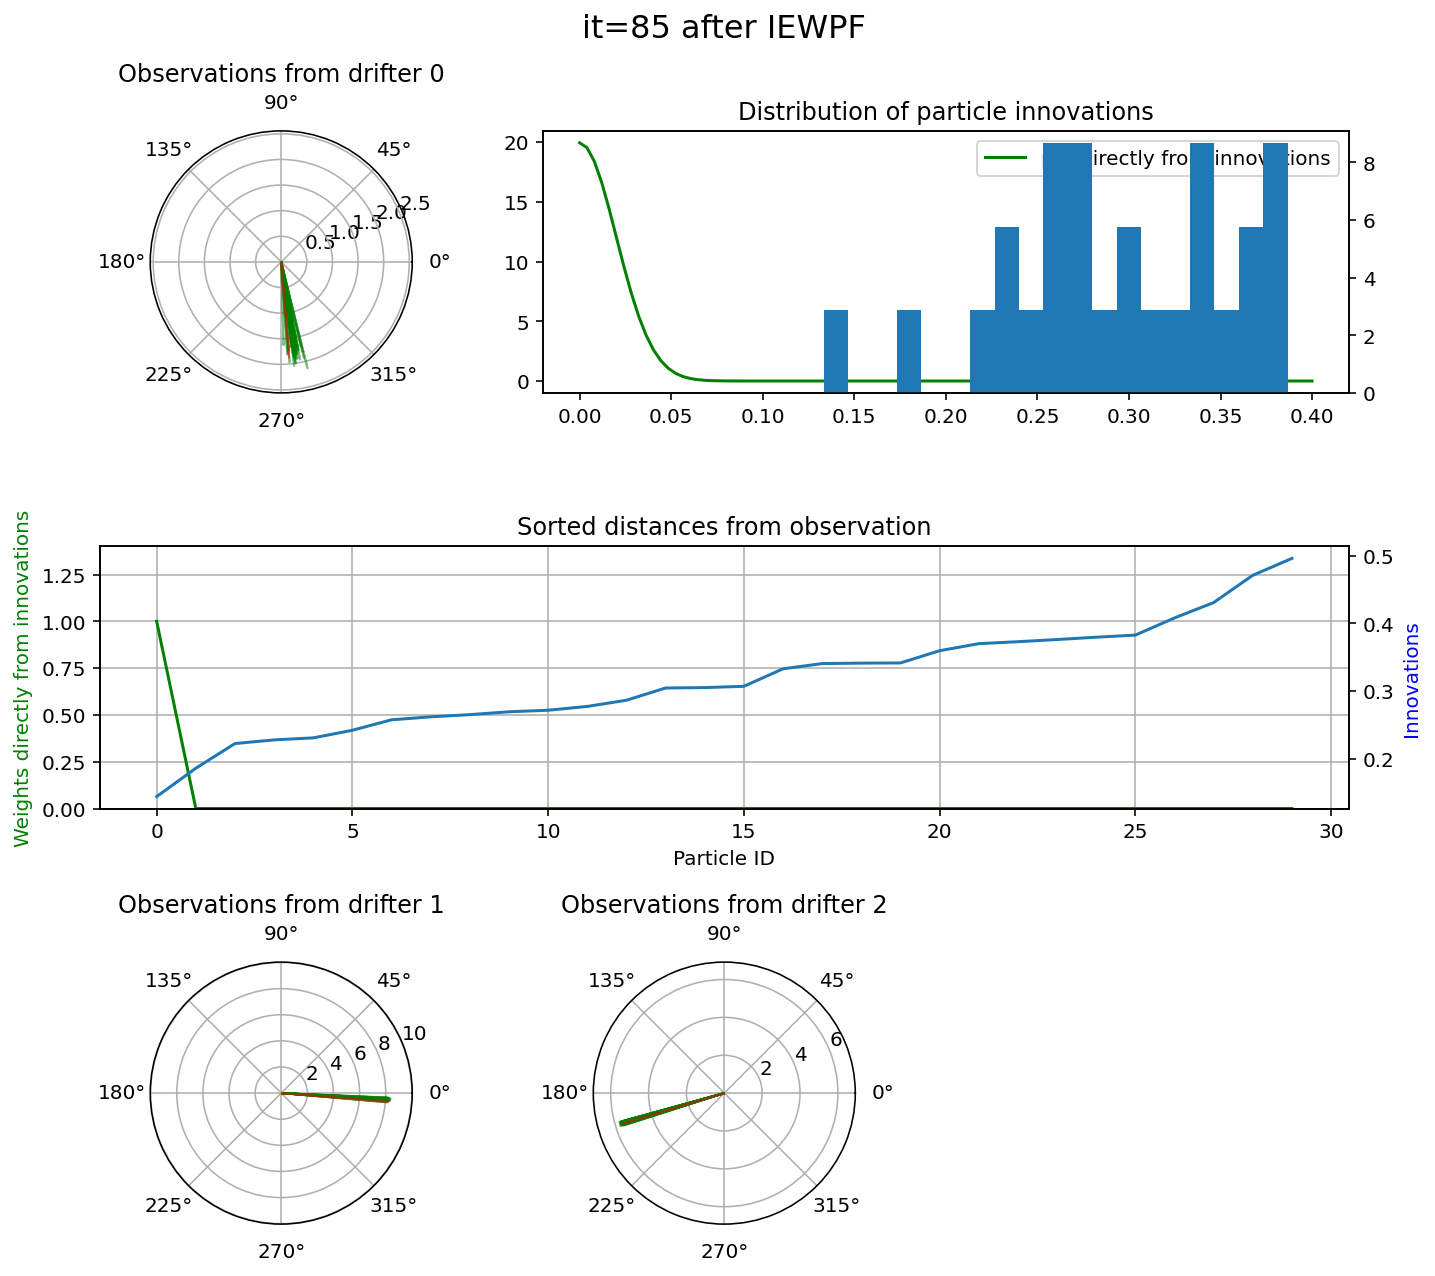

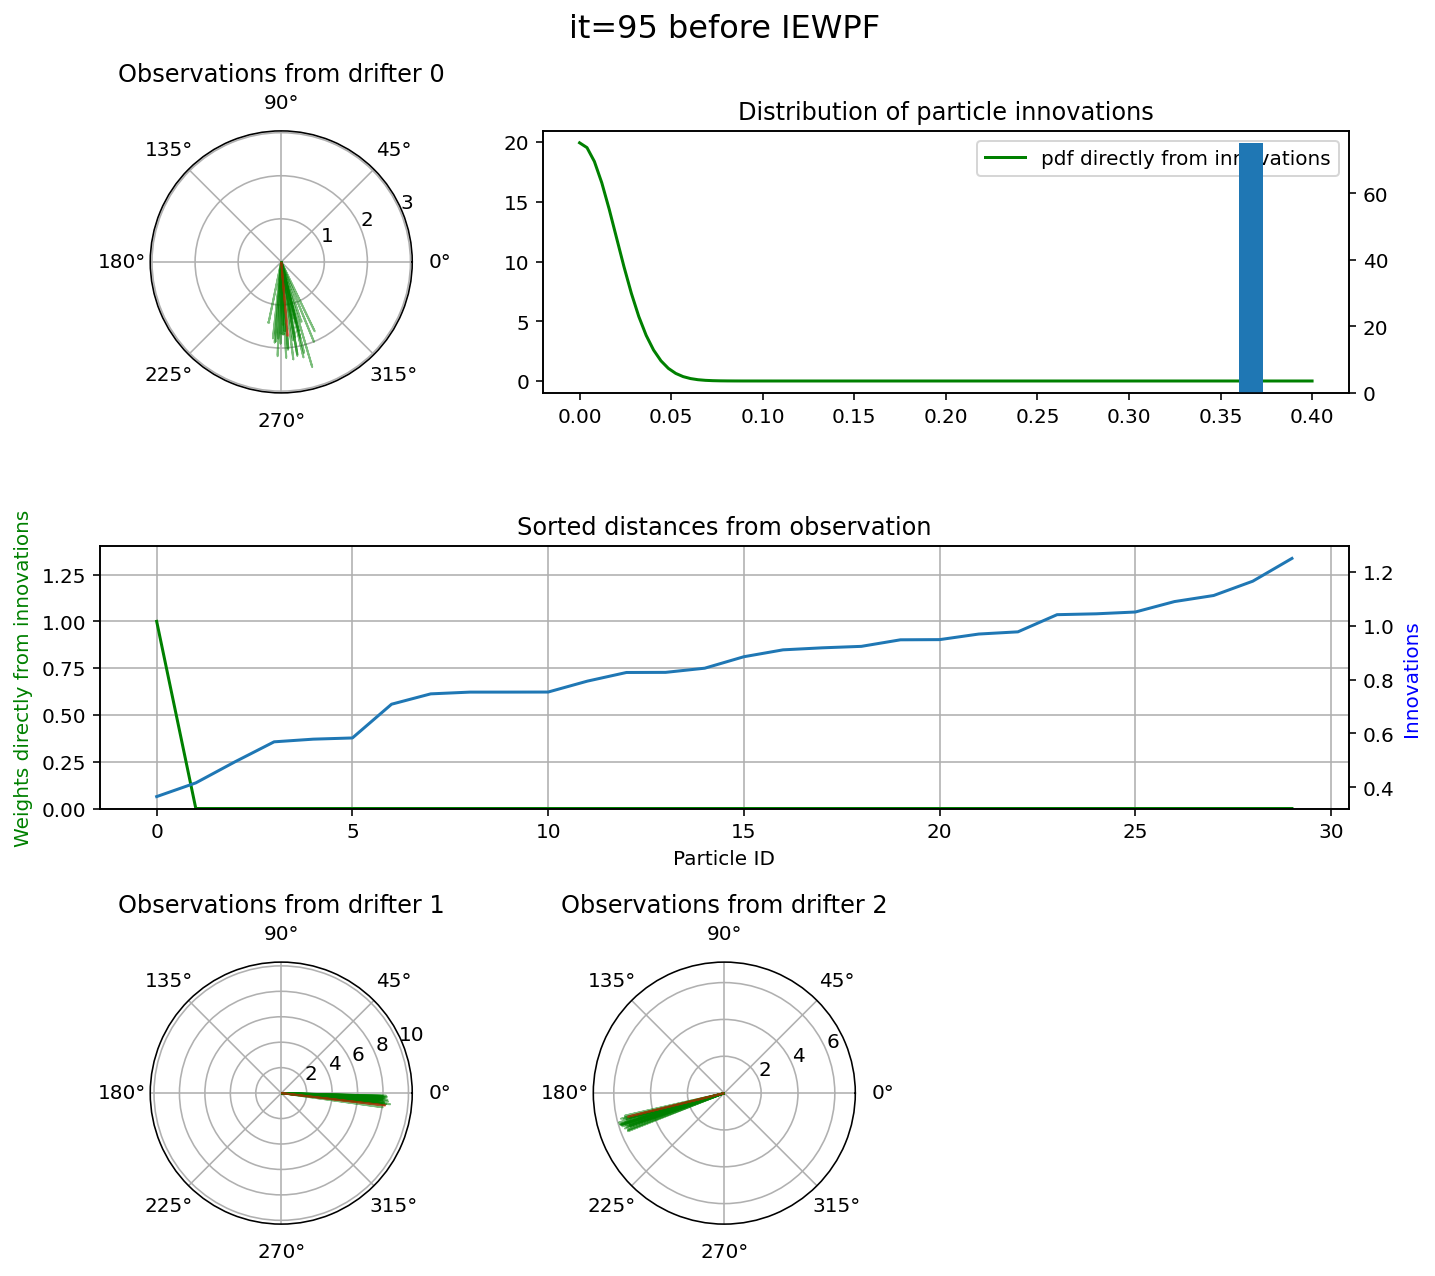

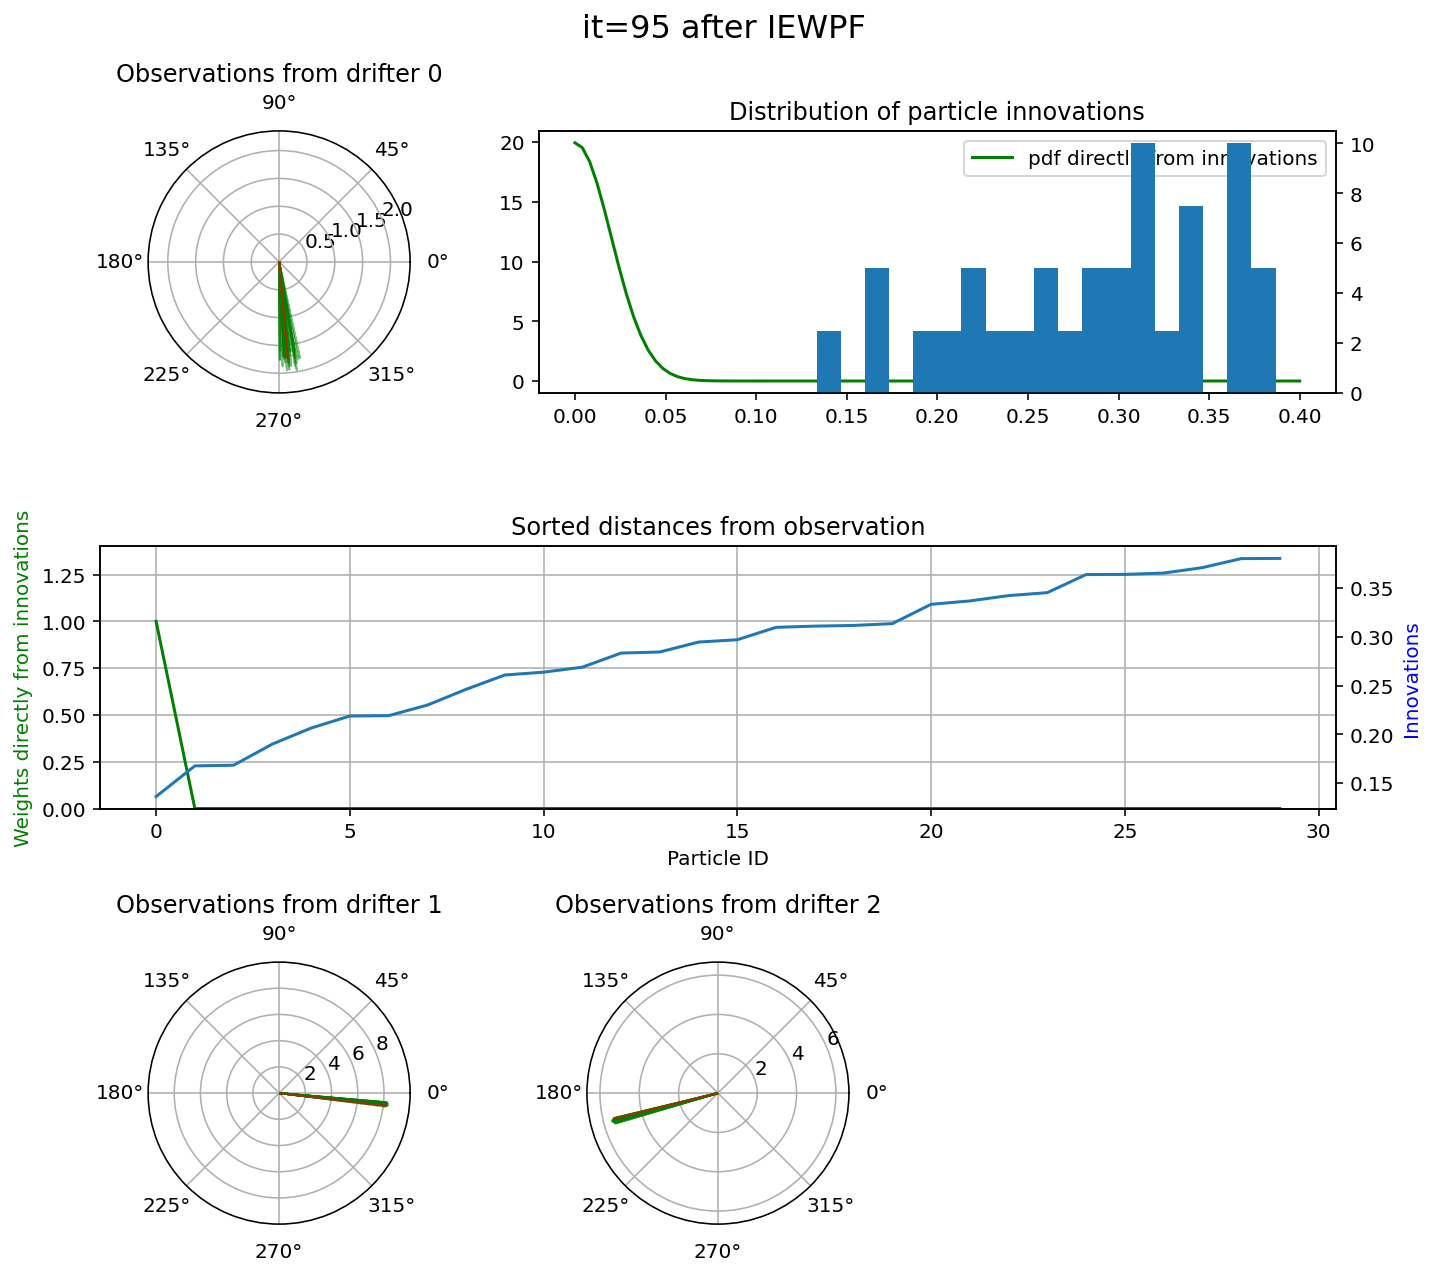

In [5]:
def show_figures(figs):
    for f in figs:
        dummy = plt.figure()
        new_manager = dummy.canvas.manager
        new_manager.canvas.figure = f
        f.set_canvas(new_manager.canvas)
        filename= "iewpf_20180720_figures/" + f._suptitle.get_text().replace(" ", "_").replace("=", "_") + ".png"
        print (filename)
        #plt.savefig(filename)
        #plt.close()
show_figures(infoPlots)
#fig = ensemble.plotDistanceInfo(title="Final ensemble")
#ensemble.plotEnsemble()
#plt.savefig("iewpf_20180720_figures/final_ensemble.png")


# Statistical evaluation

In order to check the quality of the particle filter, we investigate the following properties:

Ensemble mean:
$$\bar{\psi} = \frac{1}{N_e}\sum_{i=1}^{N_e} \psi_i$$

Standard deviation of ensemble
$$ \sigma = \sqrt{\frac{ \sum_{i=1}^{N_e} (\psi_i - \bar{\psi})^2}{N_e-1}}$$

Unbaised sample variance
$$s^2 = \frac{1}{n-1} \sum_{i=1}^{N_e} (\psi_i - \bar{\psi})^2$$

Root mean square error, compared to the truth:
$$RMSE_{truth} = \sqrt{(\bar{\psi} - \psi_{truth})^2}$$


Root mean square error, compared to the mean:
$$RMSE_{mean} = \sqrt{\sum_{i=1}^{N_e} \frac{(\psi_i - \bar{\psi})^2}{N_e}}$$


##### What we want:
Compare $\sigma$ with $RMSE_{truth}$.

Average over the domain is the better meassure.

Robust filter: Std.dev slightly larger than RMSE.

### Question
How does the above quantities compare to $q_0$ (the amplitude of the SOAR function)? It is the standard deviation.

Recap, SOAR function given by
$$ Q^{1/2}(a,b) = q_0 \left[ 1 + \frac{dist(a,b)}{L} \right] \exp \left\{ - \frac{dist(a,b)}{L} \right\},$$
and geostrophic balances
$$\delta hu_{j,k} = -\frac{g H_{j,k}}{f} \frac{\delta \eta_{j,k+1} - \delta \eta_{j, k-1}}{2 \Delta y}$$
and
$$ \delta hv_{j,k} = \frac{g H_{j,k}}{f} \frac{\delta \eta_{j+1,k} - \delta\eta_{j-1, k}}{2 \Delta x}. $$

None
None
None
0.02


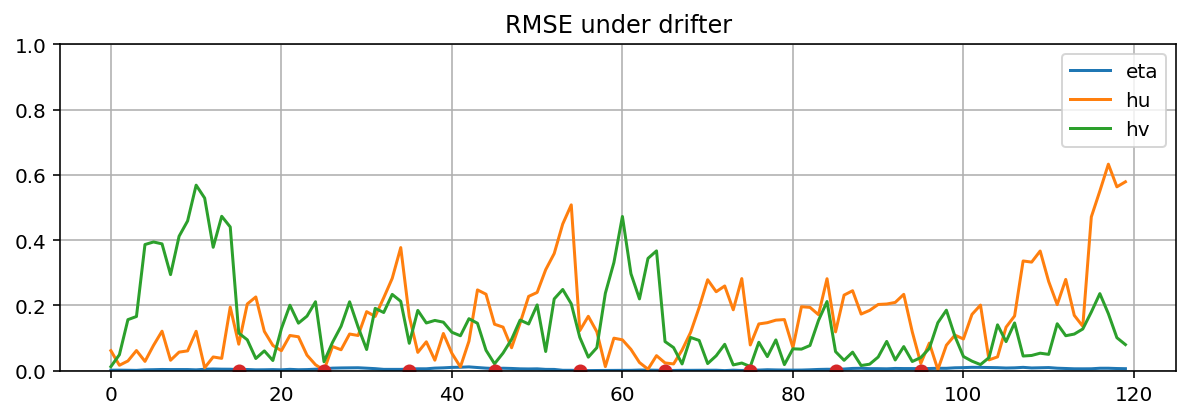

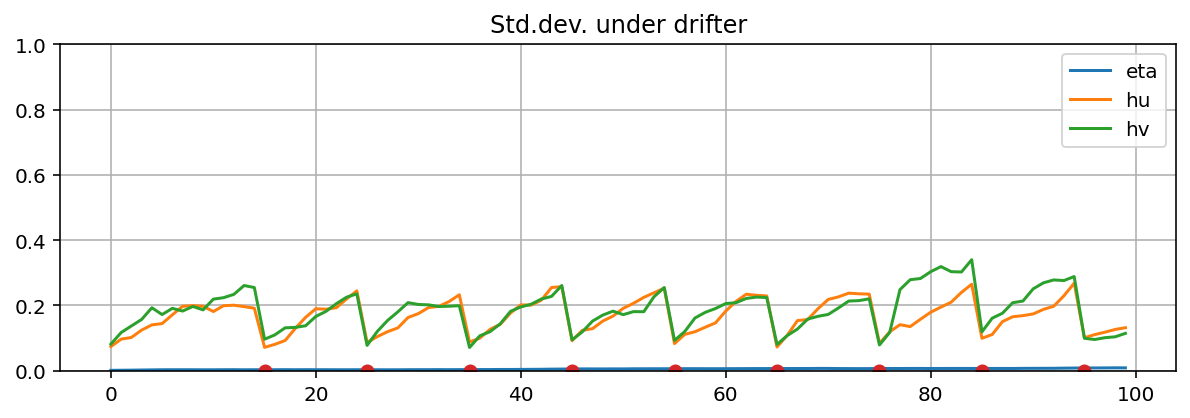

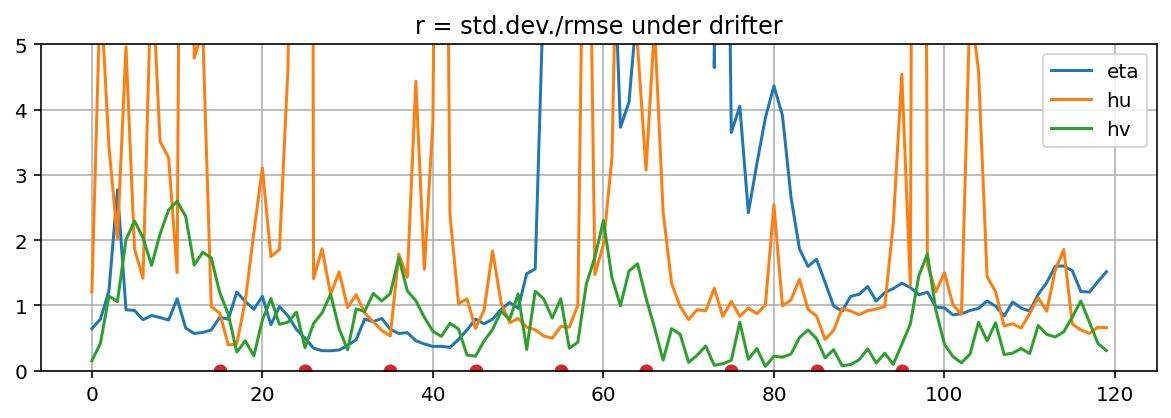

In [6]:
filename = "None"

fig = plt.figure(figsize=(10,3))
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_eta, label='eta')
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_hu,  label='hu')
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_hv,  label='hv')
plt.plot(observation_iterations, 0.0*np.ones_like(observation_iterations), 'o')
plt.title("RMSE under drifter")
plt.legend(loc=0)
plt.grid()
plt.ylim([0, 1])
#filename= "iewpf_20180720_figures/RMSE_under_drifter.png"
print (filename)
#plt.savefig(filename)

fig = plt.figure(figsize=(10,3))
plt.plot(ensemble.tArray[:100], ensemble.varianceUnderDrifter_eta[:100], label='eta')
plt.plot(ensemble.tArray[:100], ensemble.varianceUnderDrifter_hu[:100],  label='hu')
plt.plot(ensemble.tArray[:100], ensemble.varianceUnderDrifter_hv[:100],  label='hv')
plt.plot(observation_iterations, 0.0*np.ones_like(observation_iterations), 'o')
plt.title("Std.dev. under drifter")
plt.legend(loc=0)
plt.grid()
plt.ylim([0, 1
         ])
#filename= "iewpf_20180720_figures/var_under_drifter.png"
print (filename)
#plt.savefig(filename)

fig = plt.figure(figsize=(10,3))
plt.plot(ensemble.tArray, ensemble.rUnderDrifter_eta, label='eta')
plt.plot(ensemble.tArray, ensemble.rUnderDrifter_hu,  label='hu')
plt.plot(ensemble.tArray, 1.0/np.array(ensemble.rUnderDrifter_hv),  label='hv')
plt.plot(observation_iterations, 0.0*np.ones_like(observation_iterations), 'o')
plt.title("r = std.dev./rmse under drifter")
plt.legend(loc=0)
plt.grid()
plt.ylim([0, 5])
#filename= "iewpf_20180720_figures/r_under_drifter.png"
print (filename)
#plt.savefig(filename)

print (np.sqrt(ensemble.observation_cov[0,0]))

In [7]:

print( ensemble.getObservationVariance())
print( np.sqrt(ensemble.getObservationVariance()))

print( ensemble.small_scale_perturbation_amplitude)

0.0004
0.02
0.00017095321


drifter  0
drifter  1
drifter  2
drifter  0
drifter  1
drifter  2
drifter  0
drifter  1
drifter  2


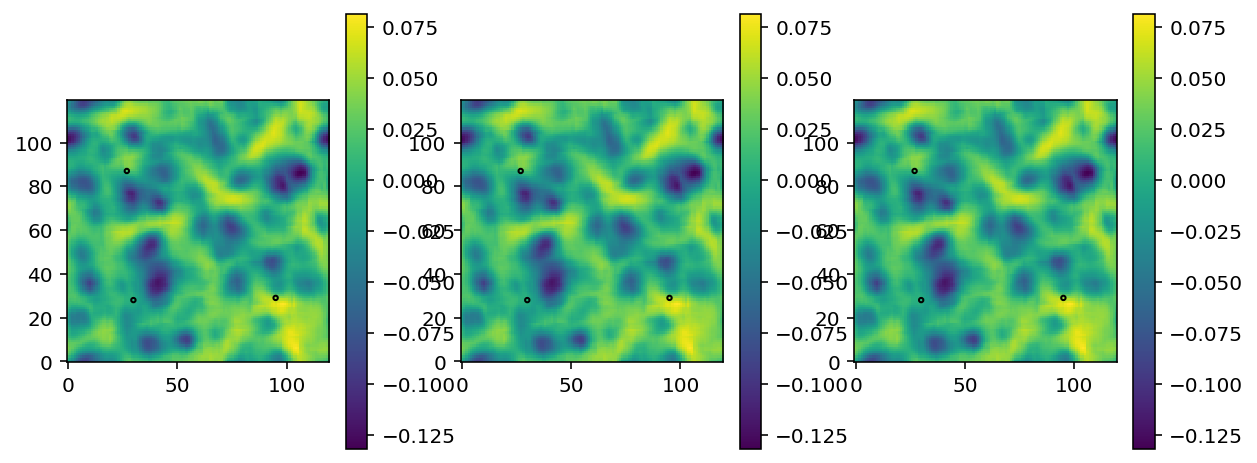

In [8]:
eta, hu, hv = ensemble.particles[0].download(interior_domain_only=True)

fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,3,1)
plt.imshow(eta, origin="lower", interpolation="None")
plt.colorbar()

ax2 = plt.subplot(1,3,2)
plt.imshow(eta, origin="lower", interpolation="None")
plt.colorbar()

ax3 = plt.subplot(1,3,3)
plt.imshow(eta, origin="lower", interpolation="None")
plt.colorbar()

#print fig
#print ax


def _markDriftersInImshow(ax):
    
    observed_drifter_positions = ensemble.observeTrueDrifters()
    for d in range(iewpfOcean.numDrifters):
        print ("drifter ", d)
        cell_id_x = int(np.floor(observed_drifter_positions[d,0]/iewpfOcean.dx))
        cell_id_y = int(np.floor(observed_drifter_positions[d,1]/iewpfOcean.dy))
        circ = matplotlib.patches.Circle((cell_id_x, cell_id_y), 1, fill=False)
        ax.add_patch(circ)

_markDriftersInImshow(ax1)
_markDriftersInImshow(ax3)
_markDriftersInImshow(ax2)

# Stepping through one iteration with one ocean state

In [9]:
if 'sim' in globals():
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()


reload(OceanStateNoise)
reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(PlotHelper)
reload(dautils)
reload(IEWPFOcean)


# Create a new ensemble with an initial perturbation
sim = CDKLM16.CDKLM16(**sim_args)
sim.perturbState(q0_scale=100)

ensemble_args["numParticles"] = 5
ensemble_args["num_drifters"] = 3
ensemble_args["sim"] = sim
ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

iewpfOcean = IEWPFOcean.IEWPFOcean(ensemble, debug=False, show_errors=True)


# Set the state of particle 0 to zero 
zeros = np.zeros((ensemble.ny+4, ensemble.nx+4), dtype=np.float32)
ensemble.particles[0].gpu_data.h0.upload(ensemble.particles[0].gpu_stream, zeros)
ensemble.particles[0].gpu_data.hu0.upload(ensemble.particles[0].gpu_stream, zeros)
ensemble.particles[0].gpu_data.hv0.upload(ensemble.particles[0].gpu_stream, zeros)

# Plot
#ensemble.plotEnsemble(num_particles=2)

The initial steps of IEWPF before looping through particles

In [10]:
# Observe true drifter positions and get innovations
observed_drifter_positions = ensemble.observeTrueDrifters()
all_innovations = ensemble.getInnovations()

# Innovation for particle 0
innovation = all_innovations[0]
print("Innovation: ", innovation)

# Get the weights before resampling - all equal, so we only make a scalar (instead of a vector)
w_rest = -np.log(1.0/ensemble.getNumParticles())
print("w_rest: ", w_rest)

# Get target weight
target_weight = iewpfOcean.obtainTargetWeight(ensemble, all_innovations)
print("target_weight: ", target_weight)

Innovation:  [[ 5.80477571  1.40606081]
 [-2.6828599   0.50349396]
 [-0.05417888 -0.34969199]]
w_rest:  1.6094379124341003
target_weight:  35360.22574245332


Now we start working with the individual particles. First, we add the Kalman gain

phi:  35358.61630454089


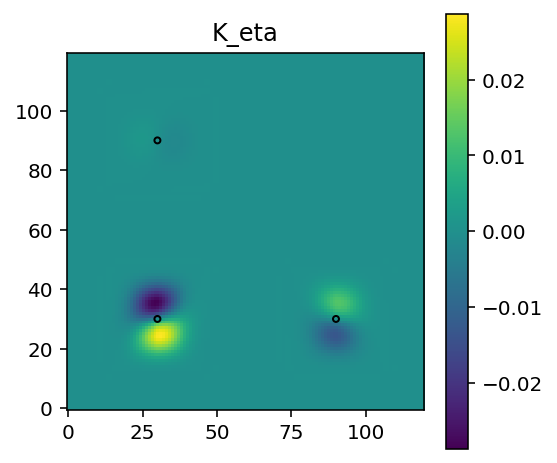

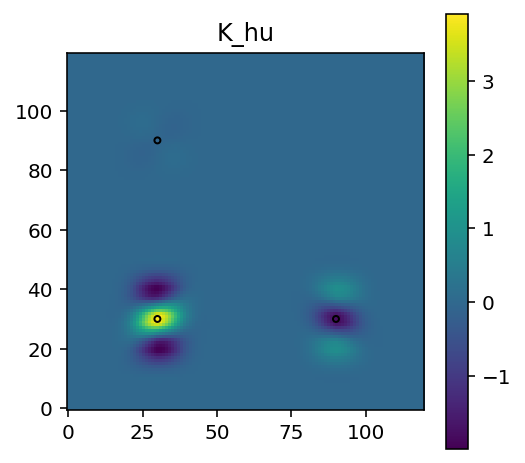

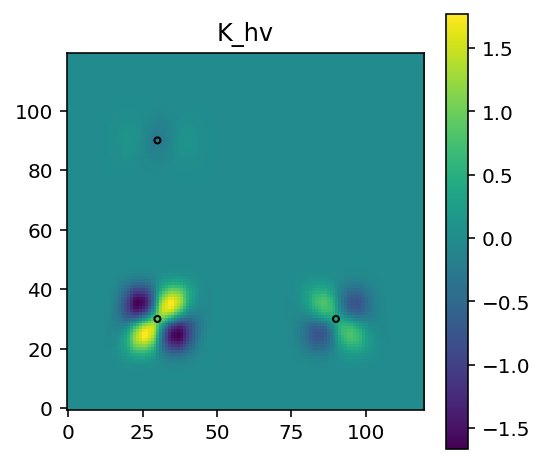

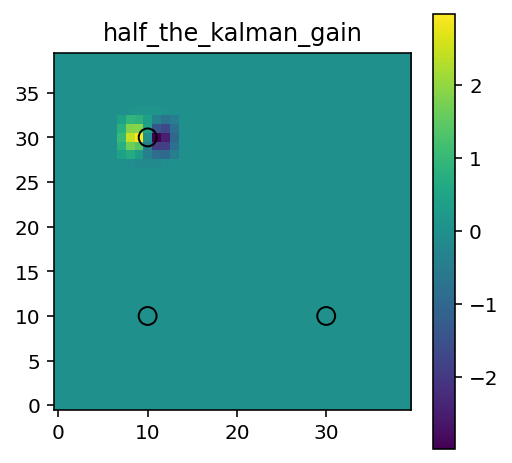

In [11]:
# Loop step 1: Pull particles towards observation by adding a Kalman gain term
#     Also, we find phi within this function
phi = iewpfOcean.addKalmanGain(ensemble.particles[0], observed_drifter_positions, innovation)
print("phi: ", phi)

# Plot the resulting Kalman gain
K_eta, K_hu, K_hv = ensemble.particles[0].download(interior_domain_only=True)

half_the_kalman_gain = ensemble.particles[0].small_scale_model_error.getRandomNumbers()

for field, title in zip([K_eta, K_hu, K_hv, half_the_kalman_gain], 
                        ["K_eta", "K_hu", "K_hv", "half_the_kalman_gain"]):
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(1, 1, 1)
    plt.imshow(field, interpolation='None', origin='lower')
    plt.title(title)
    if field.shape[0] < sim_args["ny"]:
        EnsemblePlot._markDriftersInImshow(ax, ensemble, observed_drifter_positions/sim_args["small_scale_perturbation_interpolation_factor"])
    else:
        EnsemblePlot._markDriftersInImshow(ax, ensemble, observed_drifter_positions)
    plt.colorbar()
    


Sample $\xi \sim N(0, P)$. With this function we only apply the SVD result to the standard normal distributed field.

gamma:  44954.01123046875


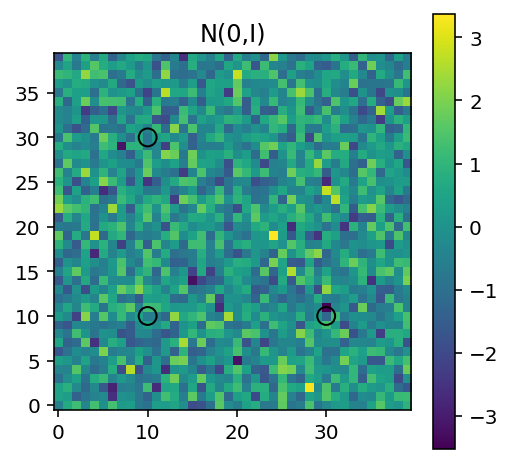

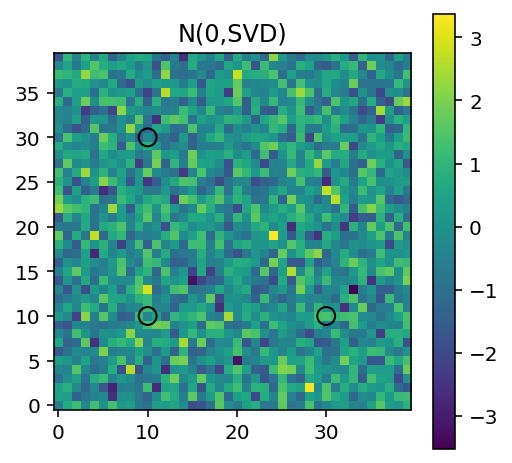

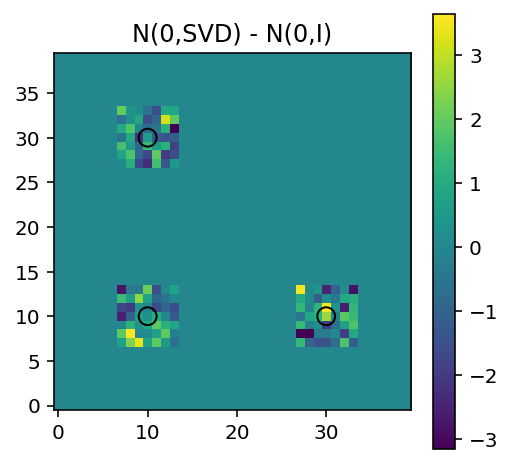

In [12]:
# Loop step 2: Sample xi \sim N(0, P), and get gamma in the process
gamma, std_norm_rand = iewpfOcean.sampleFromP(ensemble.particles[0], observed_drifter_positions, True)
print("gamma: ", gamma)

svd_rand = ensemble.particles[0].small_scale_model_error.getRandomNumbers()


for field, title in zip([std_norm_rand, svd_rand, svd_rand-std_norm_rand], 
                        ["N(0,I)", "N(0,SVD)", "N(0,SVD) - N(0,I)"]):
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(1, 1, 1)
    plt.imshow(field, interpolation='None', origin='lower')
    plt.title(title)
    EnsemblePlot._markDriftersInImshow(ax, ensemble, observed_drifter_positions/sim_args["small_scale_perturbation_interpolation_factor"])
    plt.colorbar()



In [13]:
# Loop step 3: Solve implicit equation
c_star = target_weight - (phi + w_rest)
alpha = iewpfOcean.solveImplicitEquation(gamma, target_weight, 
                                         w_rest, c_star, particle_id=0)
print("alpha: ", alpha)

# Since the ocean field is sat to zero, we accept alpha=nan

alpha:  0.9229925715320328


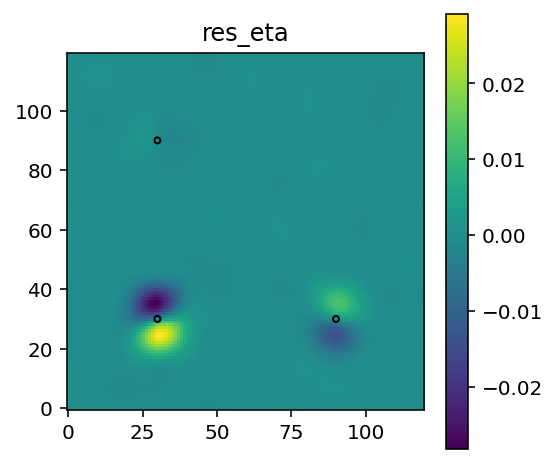

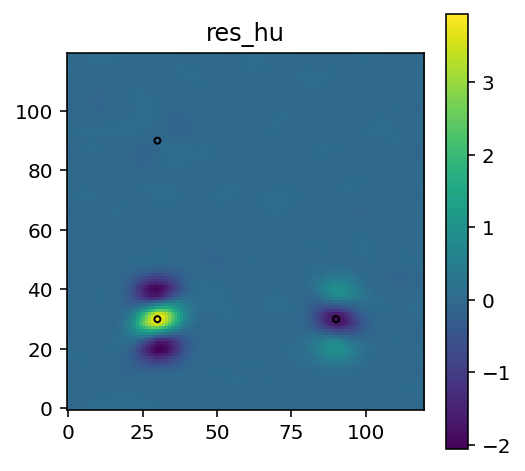

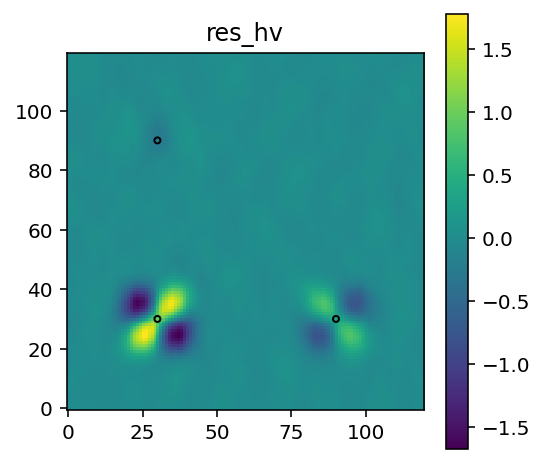

In [14]:
# Loop steps 4:Add scaled sample from P to the state vector
ensemble.particles[0].small_scale_model_error.perturbSim(ensemble.particles[0],\
                                                         update_random_field=False, \
                                                         perturbation_scale=alpha)

# Plot the resulting Kalman gain
res_eta, res_hu, res_hv = ensemble.particles[0].download(interior_domain_only=True)
for field, title in zip([res_eta, res_hu, res_hv], ["res_eta", "res_hu", "res_hv"]):
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(1, 1, 1)
    plt.imshow(field, interpolation='None', origin='lower')
    plt.title(title)
    EnsemblePlot._markDriftersInImshow(ax, ensemble, observed_drifter_positions)
    plt.colorbar()

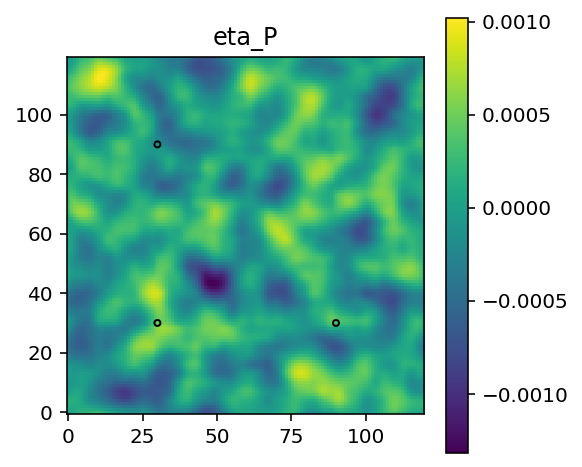

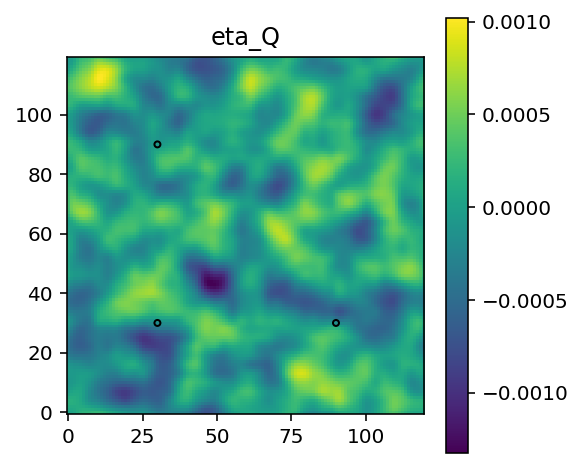

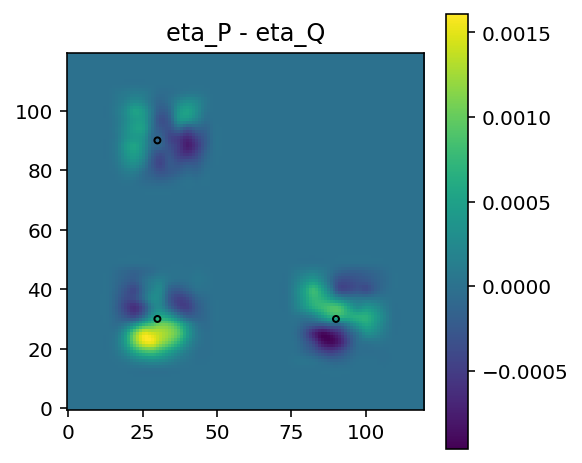

In [15]:
# Investigate how the xi sim N(0, P) was added to the solution

# From N(0, P):
eta_P, hu_P, hv_P = np.zeros(dataShape), np.zeros(dataShape), np.zeros(dataShape)
ensemble.particles[0].small_scale_model_error.random_numbers_host = svd_rand
ensemble.particles[0].small_scale_model_error.perturbOceanStateCPU(eta_P, hu_P, hv_P, sim_args["H"],
                                                                   sim_args["f"], 
                                                                   ghost_cells_x=2, ghost_cells_y=2,
                                                                   use_existing_CPU_random_numbers=True)
# From N(0, Q):
eta_Q, hu_Q, hv_Q = np.zeros(dataShape), np.zeros(dataShape), np.zeros(dataShape)
ensemble.particles[0].small_scale_model_error.random_numbers_host = std_norm_rand
ensemble.particles[0].small_scale_model_error.perturbOceanStateCPU(eta_Q, hu_Q, hv_Q, sim_args["H"],
                                                                   sim_args["f"], 
                                                                   ghost_cells_x=2, ghost_cells_y=2,
                                                                   use_existing_CPU_random_numbers=True)

# Remove the ghost cells before plotting
eta_P = eta_P[2:-2,2:-2]
hu_P  =  hu_P[2:-2,2:-2]
hv_P  =  hv_P[2:-2,2:-2]
eta_Q = eta_Q[2:-2,2:-2]
hu_Q  =  hu_Q[2:-2,2:-2]
hv_Q  =  hv_Q[2:-2,2:-2]

# Plot the resulting eta_Q and eta_P
res_eta, res_hu, res_hv = ensemble.particles[0].download(interior_domain_only=True)
for field, title in zip([eta_P, eta_Q, eta_P - eta_Q], ["eta_P", "eta_Q", "eta_P - eta_Q"]):
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(1, 1, 1)
    plt.imshow(field, interpolation='None', origin='lower')
    plt.title(title)
    EnsemblePlot._markDriftersInImshow(ax, ensemble, observed_drifter_positions)
    plt.colorbar()

In [16]:
sim.logger.getEffectiveLevel()


15